This code corresponds to the manuscript:

***"Asymmetric trichotomous partitioning overcomes dataset limitations in building machine learning models for predicting siRNA efficacy"***


### This code was developed and applied to perform:
    1) Data partitioning
    2) Model building
    3) Performance evaluation


Please cite the following manuscript when utilizing this code:

Asymmetric trichotomous data partitioning enables development of predictive machine learning models using limited siRNA efficacy datasets
Kathryn R. Monopoli, Dmitry Korkin, Anastasia Khvorova
bioRxiv 2022.07.08.499317; doi: https://doi.org/10.1101/2022.07.08.499317


**NOTE**: because of inherent randomness and small dataset size originally applied (see manuscript), when generating models, if running this code with the identical dataset the results may vary slightly. 


#### The directory setup to run these scripts is as follows:
```
trichotomous_data_partitioning_model_building
│  
│   trichotomous_data_partitioning_model_building.ipynb    
│
└───datasets
│       sirna_efficacy_data.csv
│   
└───pickled_models
│
│
└───raw_plots
```


In [53]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd
pd.reset_option('all')
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import random
import os
import matplotlib
from matplotlib import pyplot as plt


In [54]:
# Load in data 
# Data avaialable from Supplementary Data Table 1 (Shmushkovich and Monopoli et al., NAR, 2018)
raw_data_file = 'Mixset.csv' 
outdir_plot = 'raw_plots_Mixset/'
outdir_model = 'pickled_models_Mixset/'
replicate_previous_run = False # by default set to True (since some simulations take time to run this prevents re-running when unnecessary)

if replicate_previous_run:
    print('\n"replicate_previous_run" set to "True", will only re-run code if necessary\n')
else:
    print('\n"replicate_previous_run" set to "False", will FORCE all code to rerun - potentially OVERWRITING existing information\n')

    
    
if (replicate_previous_run == True): 
    # by default don't rerun unless have to 
    try:# try to get partitioned data (labeled training/testing sets) first
        df = pd.read_csv('datasets/'+raw_data_file.replace(".csv","_partitioned_K-fold.csv"))
        print("Using data that has already been partitioned into Overall Training/Holdout Sets and K-fold partitions!")

    except: # if can't find pre-partitioned data then partition it
        print("Using data that has not been partitioned into training/test set\n")
        df = pd.read_csv('datasets/'+raw_data_file)

else: 
    # replicate_previous_run set to False, then ALWAYS rerun (NOTE: and possibly overwrite previous)
    print("Forced Running NEW - data that has not been partitioned into training/test set\n")
    df = pd.read_csv('datasets/'+raw_data_file)
    

    
df.sort_values(by=['expression'],inplace=True)
df.iloc[:,1] = [i for i in df.iloc[:,1]]
display(df)




"replicate_previous_run" set to "False", will FORCE all code to rerun - potentially OVERWRITING existing information

Forced Running NEW - data that has not been partitioned into training/test set



,ID,19mer,expression,stdev
364,365,AUUAAGACGACUCGAAAUC,1.0,0
50,51,UGUUCUUCUGGAAGUCCAG,2.0,0
63,64,UAAGUCUUCUCCAGCUCCU,2.0,0
68,69,CAGAAUAAGUCUUCUCCAG,2.0,0
89,90,AACCACUGUAGAAAAUAAC,2.0,0
...,...,...,...,...
116,117,CGUCUUUCCGUGCUCCAAA,100.0,0
193,194,UCUUGGCCUUUAUGAGGAU,100.0,0
437,438,CUCUCCUCACCAGCACCGU,100.0,0
396,397,GCGAGAGGCGGACGGGACC,100.0,0


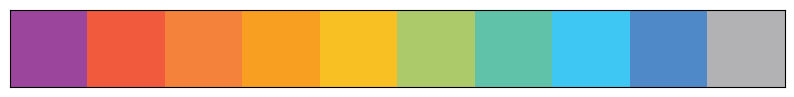

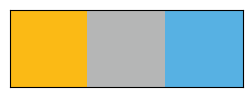

In [55]:
rainbow_color_ls = ["#9B469C","#F15A3C","#F5823A","#F89E20","#F8C022","#ADCA6B","#60C3A9","#3EC7F2","#5089C8","#B2B1B3"]
extra_purple = "#6E59A6"# for last color replacing grey in Figure 2 D
undefined_color = "#B5B6B6" # grey
func_color = "#FBBA15" # yellow 
nonfunc_color = "#57B1E3" # blue
sns.palplot(rainbow_color_ls)
sns.palplot([func_color,undefined_color,nonfunc_color])



# Select Cutoffs for Partitioning

In [11]:
len(df) / 10

47.2

In [56]:
# Devised method to split data as (relatively) evenly as possible

# Cutoff sizes of 35 and 36 distributed
co_sizes = [47,47,48,47,47,47,47,48,47,47]

ct = 0
co_range_ls = []
for co_sz in co_sizes:
    co_range_ls.append(list(df['expression'])[ct:ct+co_sz])
    ct += co_sz

if [len(x) for x in co_range_ls] != co_sizes:
    print("ERROR: sizes of cuttofs in co_range_ls do not match co_sizes")

co_ls = [x[0] for x in co_range_ls][1:]#[x[-1] for x in co_range_ls][:-1]

# NOTE: integer cutoffs just LABELS since need decimals to properly split data
co_labs = [str(int(np.round(x,0)))+"%" for x in co_ls] # New labels should be: [15, 22, 29, 36, 41, 47, 53, 65, 82]
print("Cutoffs ("+str((len(co_ls)))+" total):\n",co_ls,
      "\n\nCutoff Labels ("+str((len(co_labs)))+" total):\n",co_labs,"\n")

# Compute sizes for cutoffs
test_co_sizes = []
for i in range(len(co_ls)):
    if i >0: # subtract out previous cutoff size
        test_co_sizes.append(len(df[(df['expression'] < co_ls[i]) & (df['expression'] >= co_ls[i-1])]))

    else:
        test_co_sizes.append(len(df[df['expression'] < co_ls[i]]))
# add last part (above last cutoff)
test_co_sizes.append(len(df[df['expression'] >= co_ls[-1]]))
print("Cutoff sizes:\n",test_co_sizes)



Cutoffs (9 total):
 [6.9, 10.3, 15.0, 19.3, 29.5, 46.08, 60.0, 75.0, 90.0] 

Cutoff Labels (9 total):
 ['7%', '10%', '15%', '19%', '30%', '46%', '60%', '75%', '90%'] 

Cutoff sizes:
 [47, 45, 37, 60, 47, 47, 45, 41, 55, 48]


In [57]:
for i in range(len(co_ls)):
    indx = df[df['expression'] == co_ls[i]].index[0]
    print("cutoff:\n",co_ls[i])
    print(df.iloc[indx-2:indx+2])
    print("\n\n\n\n")
          
          

cutoff:
 6.9
      ID                19mer  expression  stdev
186  187  AGGAUCUCUCUGAUUUUUC        13.2      0
155  156  AAACACAACUCCUCCGCGC        13.2      0
232  233  AAGUCCUUGAUUACACGAU        13.3      0
271  272  UCUCAUCGGGGAAGCGCUC        13.5      0





cutoff:
 10.3
      ID                19mer  expression  stdev
256  257  UCUUUCCUCCUGUGCCAUC        15.1      0
212  213  CAAAUCCUUUCUCUCCUGU        15.1      0
275  276  UUUGAAGUUCUCAUCGGGG        15.3      0
138  139  GUUACUUGACUGGCGACGU        15.9      0





cutoff:
 15.0
      ID                19mer  expression  stdev
54    55  UCCAGCUCCUUCUUAUACU         5.0      0
64    65  AUAAGUCUUCUCCAGCUCC         5.0      0
70    71  GGCAGAAUAAGUCUUCUCC         5.0      0
177  178  CUUGCGUCGAGUUUUCCGG         5.1      0





cutoff:
 19.3
      ID                19mer  expression  stdev
155  156  AAACACAACUCCUCCGCGC        13.2      0
232  233  AAGUCCUUGAUUACACGAU        13.3      0
271  272  UCUCAUCGGGGAAGCGCUC        13.5      0

# Plot Data with all Cutoffs

Figure saved to: data_colored_by_partition.svg


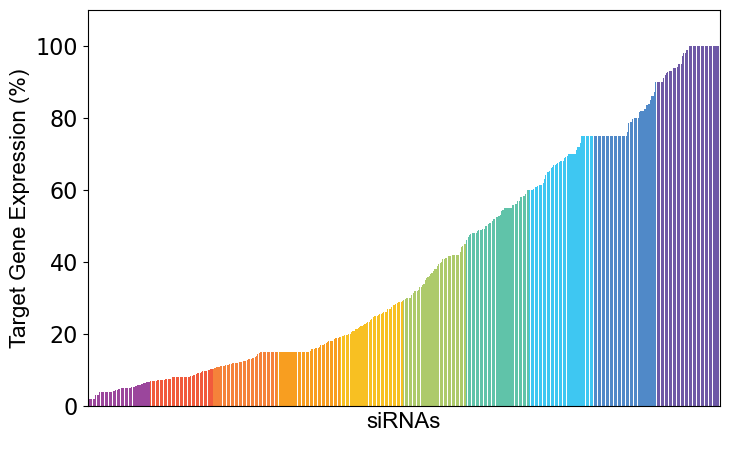

In [58]:
# plot data - all cutoffs
matplotlib.rc_file_defaults()
fntsz = 16

fig, axs = plt.subplots()
fig.set_size_inches(w=7.4, h=4.75)

colors_ls = []
for i in range(len(co_sizes)):
    if i == len(rainbow_color_ls)-1: # replace last color (grey) with purple
        colors_ls += [extra_purple]*co_sizes[i]
    colors_ls += [rainbow_color_ls[i]]*co_sizes[i]

rects = axs.bar(
    x = range(len(df)),
    height=df['expression'],
    color = colors_ls,
    yerr=df['stdev'],
)
# Set axes to start/end where desired
axs.set_xlim(0,len(df))
axs.set_ylim(0,np.round(max(df.expression))+10)
# Remove x-axis ticks
axs.set_xticks([])
axs.set_yticks(list(np.arange(0,round(max(df.expression))+20,20)))
axs.tick_params(labelsize=fntsz)

# LABEL PLOT 
axs.set_xlabel('siRNAs\n',font='Arial',fontsize = fntsz)
# axs.set_xlabel('siRNAs\n('+str(len(df))+' Total)',font='Arial',fontsize = fntsz)
axs.set_ylabel('Target Gene Expression (%)',font='Arial',fontsize = fntsz)


# # SAVE PLOT
fig.tight_layout()
fnm = ('data_colored_by_partition.svg')
fig.savefig(outdir_plot+fnm,format='svg',transparent=True)
print('Figure saved to:',fnm)
    

# Plot data with 2 cutoffs
* update cutoffs to desired cutoffs by updating **f_co** and **nf_co** variables
* selected cutoffs must be in ***co_ls***


Number Efficient siRNAs: 47
Number Inefficient siRNAs: 43
Data used in cutoffs represent 19.1% of total siRNAs (thus 80.9% of data were excluded)


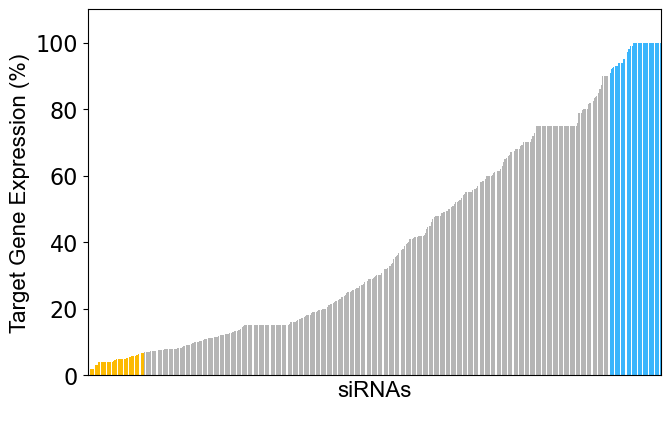

In [59]:
# plot data - all cutoffs
matplotlib.rc_file_defaults()
fntsz = 16

fig, axs = plt.subplots()
fig.set_size_inches(w=7.4, h=4.75)

f_co = co_ls[0]
nf_co = co_ls[-1]

num_f = len(df[df['expression'] < f_co])
num_nf = len(df[df['expression'] > nf_co])
num_undf = len(df)-(num_f+num_nf)

rects = axs.bar(
    x = range(len(df)),
    height=df['expression'],
    color = (['#fcba03']*num_f+
         ['#b5b5b5']*num_undf+
         ['#3ab5fc']*num_nf),
    yerr=df['stdev'],
)
# Set axes to start/end where desired
axs.set_xlim(0,len(df))
axs.set_ylim(0,np.round(max(df.expression))+10)
# Remove x-axis ticks
axs.set_xticks([])
axs.set_yticks(list(np.arange(0,round(max(df.expression))+20,20)))
axs.tick_params(labelsize=fntsz)

# LABEL PLOT 1
axs.set_xlabel('siRNAs\n',font='Arial',fontsize = fntsz)
# axs.set_xlabel('siRNAs\n('+str(len(df))+' Total)',font='Arial',fontsize = fntsz)
axs.set_ylabel('Target Gene Expression (%)',font='Arial',fontsize = fntsz)

print("Number Efficient siRNAs:",num_f)
print("Number Inefficient siRNAs:",num_nf)
print("Data used in cutoffs represent "+str(np.round(100*(((num_f+num_nf))/len(df)),1))+"% of total siRNAs"+
      " (thus "+str(np.round(100*((len(df)-(num_f+num_nf))/len(df)),1))+"% of data were excluded)"
     )
# # # SAVE PLOT
# fig.tight_layout()
# fnm = (raw_data_file.replace('.xlsx','').replace('.csv','')+'_partitioned_'+
#        'f('+str(f_co)+')_nf('+str(nf_co)+')'+'.svg'
#       )
# fig.savefig(outdir_plot+fnm,format='svg',transparent=True)
# print('Figure saved to:',fnm)
# print((num_f),"functional",(num_nf),"nonfunctional",num_undf,"undefined")
    

# Select Thresholds for Partitioning

In [60]:
# consider every possible (non-overlapping) threshold combination
co_combos = [] 
co_combos_labs = [] 
for i in range(len(co_ls)):
    for j in range(len(co_ls)):
        if co_ls[i] <= co_ls[j]:
            co_combos.append([co_ls[i], co_ls[j]])
            co_combos_labs.append([co_labs[i],co_labs[j]])
print(len(co_combos),"threshold combinations:\n",co_combos)
print("\n\n",len(co_combos_labs),"threshold combinations:\n",co_combos_labs)


45 threshold combinations:
 [[6.9, 6.9], [6.9, 10.3], [6.9, 15.0], [6.9, 19.3], [6.9, 29.5], [6.9, 46.08], [6.9, 60.0], [6.9, 75.0], [6.9, 90.0], [10.3, 10.3], [10.3, 15.0], [10.3, 19.3], [10.3, 29.5], [10.3, 46.08], [10.3, 60.0], [10.3, 75.0], [10.3, 90.0], [15.0, 15.0], [15.0, 19.3], [15.0, 29.5], [15.0, 46.08], [15.0, 60.0], [15.0, 75.0], [15.0, 90.0], [19.3, 19.3], [19.3, 29.5], [19.3, 46.08], [19.3, 60.0], [19.3, 75.0], [19.3, 90.0], [29.5, 29.5], [29.5, 46.08], [29.5, 60.0], [29.5, 75.0], [29.5, 90.0], [46.08, 46.08], [46.08, 60.0], [46.08, 75.0], [46.08, 90.0], [60.0, 60.0], [60.0, 75.0], [60.0, 90.0], [75.0, 75.0], [75.0, 90.0], [90.0, 90.0]]


 45 threshold combinations:
 [['7%', '7%'], ['7%', '10%'], ['7%', '15%'], ['7%', '19%'], ['7%', '30%'], ['7%', '46%'], ['7%', '60%'], ['7%', '75%'], ['7%', '90%'], ['10%', '10%'], ['10%', '15%'], ['10%', '19%'], ['10%', '30%'], ['10%', '46%'], ['10%', '60%'], ['10%', '75%'], ['10%', '90%'], ['15%', '15%'], ['15%', '19%'], ['15%', '30%'],

# Data Partitioning into Training/Holdout

In [61]:
# Split data into Overall Training Set (75%) and Overall Holdout Set (25%)
#    For EACH threshold combination, Partition Data Randomly into Training and Holdout Sets

training_set_size = 0.75 
holdout_set_size = 0.25

if (replicate_previous_run == True): 
    # by default don't rerun unless have to 
    if 'f_co_'+co_combos_labs[0][0]+'__nf_co_'+co_combos_labs[0][1]+'_class' not in df.columns: 
        # data have NOT been partitioned into Overall Training/Overall Holdout yet
        print("Partitioning data into Overall Training/Holdout Sets")
        
        # need to classify data for each threshold combo so that equally distribute efficient/inefficient siRNAs into Training/Holdout sets
        colname_ls = []
        for i in range(len(co_combos)):
            f_co = co_combos[i][0]
            nf_co = co_combos[i][1]

            # make 2 empty columns for given cutoff combo: 1) partition (train/test), 2) class (efficient/inefficient/undefined)
            colname = 'f_co_'+co_combos_labs[i][0]+'__nf_co_'+co_combos_labs[i][1]
            df[colname+'_class'] = np.nan
            df[colname+'_partition'] = np.nan
            colname_ls.append(colname)

            # classify (efficient/inefficient/undefined) by cutoff combo
            df.loc[df['expression']<f_co,colname+'_class'] = 'efficient'
            df.loc[df['expression']>=nf_co,colname+'_class'] = 'inefficient'
            df.loc[((df['expression']>=f_co) & (df['expression']<nf_co)),colname+'_class'] = 'undefined'

            # indicies of all efficient siRNAs
            random_pos_train = random.sample( list(df.index) , int(len(list(df.index))*training_set_size) )
            random_pos_holdout = [x for x in range(0, len(df)) if x not in random_pos_train]

            random_pos_train.sort()
            random_pos_holdout.sort()

            df.loc[random_pos_train,colname+'_partition'] = 'training'
            df.loc[random_pos_holdout,colname+'_partition'] = 'holdout'




        # export partitioned data to a file
        fnm='datasets/'+raw_data_file.replace(".csv","_partitioned.csv")
        df.to_csv(fnm,index=False)
        print("Data saved to:\n",fnm)


    else:
        # data have ALREADY been partitioned into Overall Training/Overall Holdout 
        print("Data are already partitioned into Overall Training/Holdout Sets")
        colname_ls = [x.replace("_partition",'') for x in list(df.columns) if (  'partition' in x)]

else: 
    # replicate_previous_run set to False, then ALWAYS rerun (NOTE: and possibly overwrite previous)
    print("Forced Running NEW - partitioning into Overall Training and Overall Holdout Sets")
    
    # need to classify data for each threshold combo so that equally distribute efficient/inefficient siRNAs into Training/Holdout sets
    colname_ls = []
    for i in range(len(co_combos)):
        f_co = co_combos[i][0]
        nf_co = co_combos[i][1]

        # make 2 empty columns for given cutoff combo: 1) partition (train/test), 2) class (efficient/inefficient/undefined)
        colname = 'f_co_'+co_combos_labs[i][0]+'__nf_co_'+co_combos_labs[i][1]
        df[colname+'_class'] = np.nan
        df[colname+'_partition'] = np.nan
        colname_ls.append(colname)

        # classify (efficient/inefficient/undefined) by cutoff combo
        df.loc[df['expression']<f_co,colname+'_class'] = 'efficient'
        df.loc[df['expression']>=nf_co,colname+'_class'] = 'inefficient'
        df.loc[((df['expression']>=f_co) & (df['expression']<nf_co)),colname+'_class'] = 'undefined'

        # indicies of all efficient siRNAs
        random_pos_train = random.sample( list(df.index) , int(len(list(df.index))*training_set_size) )
        random_pos_holdout = [x for x in range(0, len(df)) if x not in random_pos_train]

        random_pos_train.sort()
        random_pos_holdout.sort()

        df.loc[random_pos_train,colname+'_partition'] = 'training'
        df.loc[random_pos_holdout,colname+'_partition'] = 'holdout'



    # export partitioned data to a file
    fnm='datasets/'+raw_data_file.replace(".csv","_partitioned.csv")
    df.to_csv(fnm,index=False)
    print("Data saved to:\n",fnm)




Forced Running NEW - partitioning into Overall Training and Overall Holdout Sets
Data saved to:
 datasets/Mixset_partitioned.csv


# Divide each training set partition group into K (10) folds 
## and save results to file so repeatable

In [62]:
if (replicate_previous_run == True): 
    # by default don't rerun unless have to 
    if 'f_co_'+co_combos_labs[0][0]+'__nf_co_'+co_combos_labs[0][1]+'_K-part' not in df.columns:
        print("Making K-fold partions")
        for col in colname_ls:
            print()
            # get indicies of all training data for given threshold combo
            training_indxs = list(df[df[col+'_partition']=='training'].index)
            holdout_indxs = list(df[df[col+"_partition"]=='holdout'].index)
            # randomly partition training data for given partition into K (10) groups
            # shuffle indicies
            random.shuffle(training_indxs)
            # split indicies by 10's
            k_part_size_1 = int(len(training_indxs)/10)
            remaining_to_distribute = len(training_indxs)%10

            k_partitions = [training_indxs[i::10] for i in range(10)]
            print([len(x) for x in k_partitions])
            print(k_partitions)
            print("\n\nItems in k_fold_partitions are unique:",len(([x for x_s in k_partitions for x in x_s])) == len(set([x for x_s in k_partitions for x in x_s])),"\n\n")



            # add column in df to indicate which k_part training data are in (so repeatable)
            df[col+"_K-part"] = np.nan
            for i in range(len(k_partitions)):
                df.loc[k_partitions[i]]
                df.loc[k_partitions[i],col+"_K-part"] = i+1
            df.loc[holdout_indxs,col+"_K-part"] = 'N/A (holdout)'


        # export K-fold partitioned data to a file
        fnm='datasets/'+raw_data_file.replace(".csv","_partitioned_K-fold.csv")
        df.to_csv(fnm,index=False)
        print("Data saved to:\n",fnm)
        
    else:
        print("K-fold partitions already created!")

else: 
    # replicate_previous_run set to False, then ALWAYS rerun (NOTE: and possibly overwrite previous)
    print("Forced Running NEW - making K-fold partitions")
    for col in colname_ls:
        print()
        # get indicies of all training data for given threshold combo
        training_indxs = list(df[df[col+'_partition']=='training'].index)
        holdout_indxs = list(df[df[col+"_partition"]=='holdout'].index)
        # randomly partition training data for given partition into K (10) groups
        # shuffle indicies
        random.shuffle(training_indxs)
        # split indicies by 10's
        k_part_size_1 = int(len(training_indxs)/10)
        remaining_to_distribute = len(training_indxs)%10

        k_partitions = [training_indxs[i::10] for i in range(10)]
        print([len(x) for x in k_partitions])
        print(k_partitions)
        print("\n\nItems in k_fold_partitions are unique:",len(([x for x_s in k_partitions for x in x_s])) == len(set([x for x_s in k_partitions for x in x_s])),"\n\n")



        # add column in df to indicate which k_part training data are in (so repeatable)
        df[col+"_K-part"] = np.nan
        for i in range(len(k_partitions)):
            df.loc[k_partitions[i]]
            df.loc[k_partitions[i],col+"_K-part"] = i+1
        df.loc[holdout_indxs,col+"_K-part"] = 'N/A (holdout)'


    # export K-fold partitioned data to a file
    fnm='datasets/'+raw_data_file.replace(".csv","_partitioned_K-fold.csv")
    df.to_csv(fnm,index=False)
    print("Data saved to:\n",fnm)

    
    
    

Forced Running NEW - making K-fold partitions

[36, 36, 36, 36, 35, 35, 35, 35, 35, 35]
[[377, 155, 258, 256, 254, 317, 67, 299, 221, 149, 145, 276, 172, 18, 77, 438, 154, 365, 37, 118, 204, 432, 209, 360, 321, 170, 406, 335, 344, 66, 316, 120, 129, 45, 200, 298], [247, 60, 460, 121, 224, 158, 119, 324, 153, 111, 101, 44, 139, 192, 89, 231, 257, 91, 138, 46, 230, 186, 456, 33, 297, 309, 329, 174, 79, 61, 137, 65, 466, 171, 127, 455], [53, 373, 300, 420, 34, 157, 453, 301, 419, 93, 350, 182, 433, 388, 222, 442, 83, 38, 454, 143, 323, 418, 239, 85, 413, 136, 429, 82, 337, 470, 266, 387, 286, 92, 69, 345], [407, 383, 437, 211, 334, 56, 403, 271, 51, 249, 393, 428, 28, 238, 462, 20, 306, 178, 84, 261, 295, 375, 368, 59, 260, 331, 140, 469, 189, 378, 151, 23, 103, 341, 262, 381], [278, 14, 396, 73, 184, 95, 386, 374, 445, 424, 52, 330, 88, 310, 71, 42, 236, 471, 458, 193, 197, 132, 315, 62, 312, 259, 290, 355, 285, 464, 376, 302, 234, 128, 167], [206, 27, 468, 144, 444, 229, 163, 218, 303, 

In [19]:
df

,ID,19mer,expression,stdev,f_co_7%__nf_co_7%_class,f_co_7%__nf_co_7%_partition,f_co_7%__nf_co_10%_class,f_co_7%__nf_co_10%_partition,f_co_7%__nf_co_15%_class,f_co_7%__nf_co_15%_partition,...,f_co_46%__nf_co_46%_K-part,f_co_46%__nf_co_60%_K-part,f_co_46%__nf_co_75%_K-part,f_co_46%__nf_co_90%_K-part,f_co_60%__nf_co_60%_K-part,f_co_60%__nf_co_75%_K-part,f_co_60%__nf_co_90%_K-part,f_co_75%__nf_co_75%_K-part,f_co_75%__nf_co_90%_K-part,f_co_90%__nf_co_90%_K-part
364,365,AUUAAGACGACUCGAAAUC,1.0,0,efficient,training,efficient,training,efficient,training,...,8.0,5.0,8.0,9.0,1.0,8.0,5.0,N/A (holdout),2.0,6.0
50,51,UGUUCUUCUGGAAGUCCAG,2.0,0,efficient,training,efficient,holdout,efficient,training,...,3.0,6.0,N/A (holdout),1.0,N/A (holdout),2.0,10.0,5.0,4.0,6.0
63,64,UAAGUCUUCUCCAGCUCCU,2.0,0,efficient,holdout,efficient,holdout,efficient,training,...,5.0,2.0,N/A (holdout),6.0,6.0,2.0,9.0,N/A (holdout),N/A (holdout),1.0
68,69,CAGAAUAAGUCUUCUCCAG,2.0,0,efficient,training,efficient,training,efficient,training,...,2.0,3.0,10.0,7.0,N/A (holdout),5.0,1.0,5.0,N/A (holdout),4.0
89,90,AACCACUGUAGAAAAUAAC,2.0,0,efficient,holdout,efficient,training,efficient,training,...,7.0,7.0,N/A (holdout),5.0,5.0,N/A (holdout),3.0,3.0,3.0,N/A (holdout)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,117,CGUCUUUCCGUGCUCCAAA,100.0,0,inefficient,training,inefficient,training,inefficient,training,...,N/A (holdout),10.0,N/A (holdout),3.0,1.0,3.0,N/A (holdout),8.0,N/A (holdout),1.0
193,194,UCUUGGCCUUUAUGAGGAU,100.0,0,inefficient,training,inefficient,holdout,inefficient,holdout,...,10.0,5.0,8.0,N/A (holdout),4.0,N/A (holdout),N/A (holdout),2.0,4.0,4.0
437,438,CUCUCCUCACCAGCACCGU,100.0,0,inefficient,holdout,inefficient,training,inefficient,training,...,5.0,N/A (holdout),9.0,4.0,5.0,N/A (holdout),4.0,4.0,N/A (holdout),10.0
396,397,GCGAGAGGCGGACGGGACC,100.0,0,inefficient,holdout,inefficient,training,inefficient,holdout,...,7.0,7.0,2.0,4.0,9.0,1.0,2.0,N/A (holdout),1.0,N/A (holdout)


In [63]:
df['f_co_30%__nf_co_30%_K-part'].value_counts()

f_co_30%__nf_co_30%_K-part
N/A (holdout)    118
3.0               36
1.0               36
2.0               36
4.0               36
8.0               35
9.0               35
7.0               35
5.0               35
6.0               35
10.0              35
Name: count, dtype: int64

In [64]:
df['f_co_30%__nf_co_30%_partition'].value_counts()

f_co_30%__nf_co_30%_partition
training    354
holdout     118
Name: count, dtype: int64

#### Determining if have correct number of groups of data:
* have 45 threshold combinations:
    * 1 overall training set (75% of data  ~267 siRNAs)
    * 1 overall holdout  set (25% of data  ~89 siRNAs)

* k = 10 subsets
* then should have:
    * 45 overall holdout sets
    * 45 * k = 45 * 10 = 450 training sets (each with 9 training subsets and 1 test subset)
    * 450 + 45 = 495 so should have **495 groups of data**


In [65]:
nm_k_temp = len([x for x in list(df['f_co_30%__nf_co_30%_K-part'].value_counts().index) if x != 'N/A (holdout)']) # number of k-partitions
nm_col_k_part_temp =len([ x for x in df.columns if 'K-part' in x]) # number of of columns containing K-partition information 
nm_hldout_temp = len([ x for x in df.columns if '_partition' in x]) # number of holdout set groups

print("This values should equal 495:\n",(nm_k_temp*nm_col_k_part_temp)+ nm_hldout_temp) # should equal 495




This values should equal 495:
 495


# Plot cutoff combinations
**NOTE**: plots ALL 45 cutoff combinations in a grid for both Training and Holdout sets so ***may take a few minutes to run if running locally***

order of plots:
training
holdout


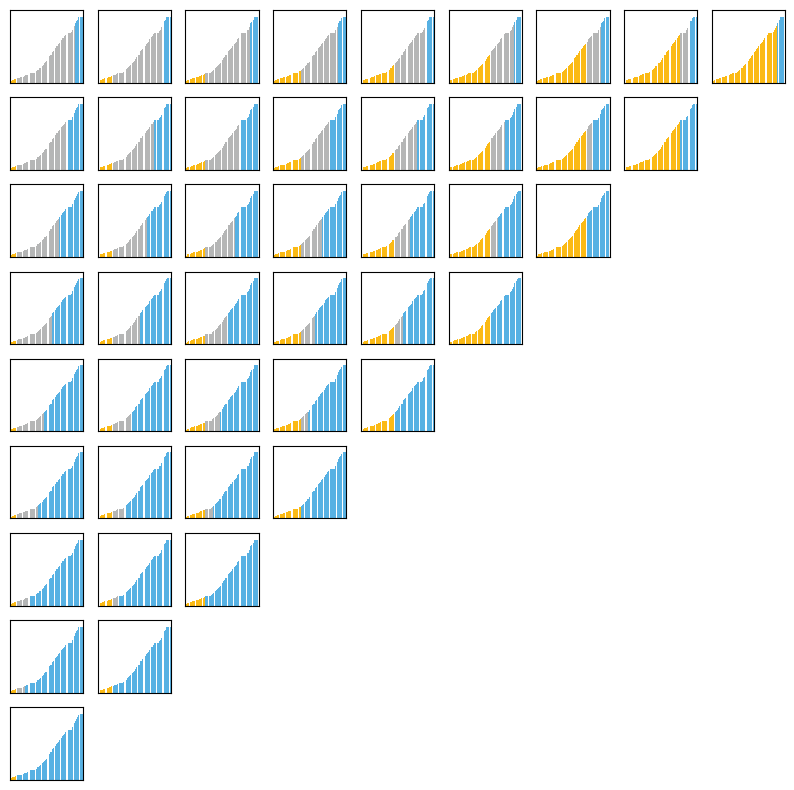

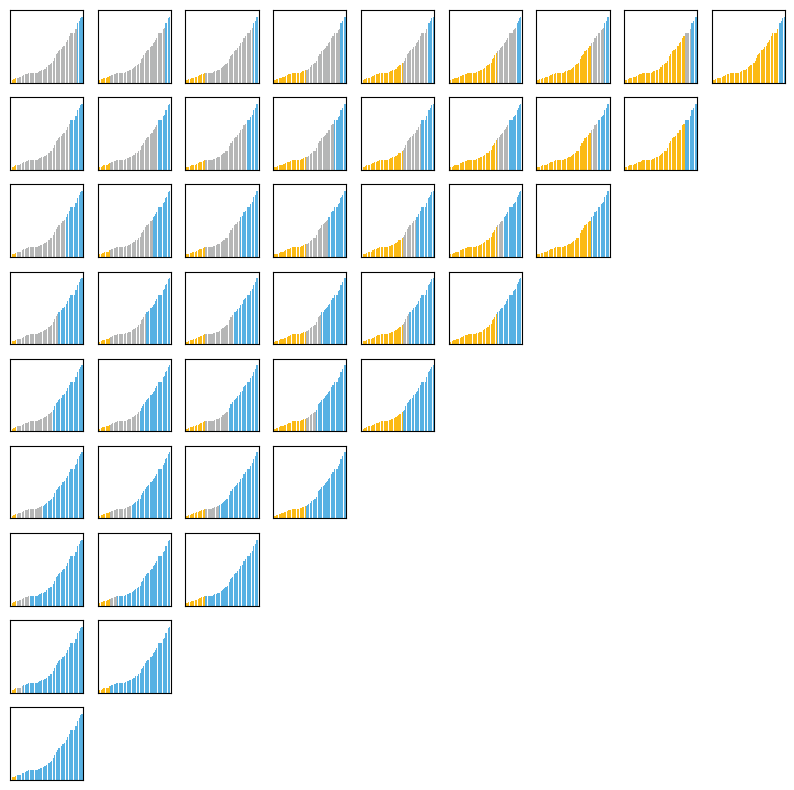

In [66]:
# Plot data - cutoff combinations as a grid
#    Plot Overall Training and Holdout Sets separately

colname_ls
co_combos


fig1, axs1 = plt.subplots(9,9)
fig1.set_size_inches(w=10, h=10)

fig2, axs2 = plt.subplots(9,9)
fig2.set_size_inches(w=10, h=10)

eff_co_lab_simp_ls =   [x.replace("%","") for x in co_labs]
ineff_co_lab_simp_ls = [x.replace("%","") for x in co_labs][::-1]
print("order of plots:")
# plots SEPARATELY overall training (75%) and overall test (25%) sets
for p in ['training','holdout']: # plot the training and holdout separately!
    print(p)
    for i in range(9):
        for j in range(9):
            # select axis to plot
            if p == 'training':
                ax = axs1[i,j] #ax = axs[i,j]
            else:
                ax = axs2[i,j] #ax = axs[i,j]
                
            # if axis belongs to overlapping threshold combination, remove it
            if i+j>8:
                ax.remove()
            else:
                f_co = eff_co_lab_simp_ls[j]
                nf_co = ineff_co_lab_simp_ls[i]

                #ax.text(1,7,s="( i:"+str(i)+", j:"+str(j)+")")
                #ax.text(0,3,s=('f_co_'+str(eff_co_lab_simp_ls[j])+'%__nf_co_'+str(ineff_co_lab_simp_ls[i])+'%_class'))


                threshold_lab_temp='f_co_'+str(f_co)+'%__nf_co_'+str(nf_co)+'%_class'

                color_ls = (
                    # 'f_co_30%__nf_co_30%_partition' cutoff combination has no undefined data and therefore will have all info about partitioning 
                    ['#FBBA15']*len(df[(df[threshold_lab_temp] == 'efficient') & (df['f_co_30%__nf_co_30%_partition'] == p)])+
                    ['#B5B6B6']*len(df[(df[threshold_lab_temp] == 'undefined') & (df['f_co_30%__nf_co_30%_partition'] == p)])+
                    ['#57B1E3']*len(df[(df[threshold_lab_temp] == 'inefficient') & (df['f_co_30%__nf_co_30%_partition'] == p)]))
                

                # plot expression data (NOTE: the data itself stays the same for each cutoff, just the coloring of efficient/undefined/inefficient changes)
                rects = ax.bar(
                    # 'f_co_30%__nf_co_30%_partition' cutoff combination has no undefined data and therefore will have all info about partitioning 
                    x = range(len(df[df['f_co_30%__nf_co_30%_partition'] == p])),#range(len(df.loc[random_pos_train])),
                    height=df[df['f_co_30%__nf_co_30%_partition'] == p]['expression'],#df.loc[random_pos_train]['expression'],
                    yerr=df[df['f_co_30%__nf_co_30%_partition'] == p]['stdev'],#df.loc[random_pos_train]['stdev'],
                    color = color_ls,
                )

                # ** FORMAT AXES **
                # Set axes to start/end where desired
                ax.set_xlim(0,len(df[df['f_co_30%__nf_co_30%_partition'] == p]))# len(0,df.loc[random_pos_train])
                ax.set_ylim(0,np.round(max(df['expression']))+10)
                # Remove x-axis ticks
                ax.set_xticks([])
                # Remove y-axis ticks
                ax.set_yticks([])
                # Change x-axis tick labels (and rotate)
                # ax.set_xticklabels(['t'+str(x) for x in range(21)[1:]], rotation=0)
                # Add horizontal line cross at 0
                # ax.axhline(y=0, xmin=0, xmax=1, color='black', lw=1)
                # # Change both x and y axis label font size
                # ax.tick_params(labelsize=10)



plt.show()



# Prep data for model training
#### Exclude undefined values from Training and Holdout sets

In [67]:
# Update all undefined sequences in the holdout dataset to "excluded"
for colname in colname_ls:
    indicies_holdout_undef = list(df[(df[colname+'_class'] == 'undefined') & (df[colname+'_partition'] == 'holdout')].index)
    df.loc[indicies_holdout_undef , colname+'_class'] = 'excluded'   # note use comma "," to select column when updating values     

# Update all undefined sequences in the training dataset to "excluded" 
for colname in colname_ls:
    indicies_training_undef = list(df[(df[colname+'_class'] == 'undefined') & (df[colname+'_partition'] == 'training')].index)
    df.loc[indicies_training_undef , colname+'_class'] = 'excluded'   # note use comma "," to select column when updating values     

# NOTE: 'f_co_15%__nf_co_82%_partition' cutoff combination is just selected as an example for testing because it contains undefined (middle) values
df[df['f_co_30%__nf_co_30%_partition'] == 'training']['f_co_30%__nf_co_30%_class'].value_counts()




f_co_30%__nf_co_30%_class
inefficient    187
efficient      167
Name: count, dtype: int64

In [68]:
# NOTE: 'f_co_15%__nf_co_82%_partition' cutoff combination is just selected as an example for testing because it contains undefined (middle) values
print(df[df['f_co_30%__nf_co_30%_partition'] == 'holdout']['f_co_30%__nf_co_30%_class'].value_counts())
print(df[df['f_co_30%__nf_co_30%_partition'] == 'training']['f_co_30%__nf_co_30%_class'].value_counts())


f_co_30%__nf_co_30%_class
efficient      69
inefficient    49
Name: count, dtype: int64
f_co_30%__nf_co_30%_class
inefficient    187
efficient      167
Name: count, dtype: int64


# Encode sequences (19mers)

In [69]:
# Encode sequence
def encode_sequence(seq):
    base_dict = {'A':[1,0,0,0],'U':[0,1,0,0],'C':[0,0,1,0],'G':[0,0,0,1]}
    seq_encoded = []
    for base in seq:
        seq_encoded.append(base_dict[base])
    
    # flatten list
    seq_encoded =   [item for items in seq_encoded for item in items]
    return seq_encoded


df['encoded_19mer'] = df['19mer'].apply(lambda x: encode_sequence(x))


df['encoded_19mer'] 


364    [1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...
50     [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, ...
63     [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
68     [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...
89     [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...
                             ...                        
116    [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, ...
193    [0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, ...
437    [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...
396    [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, ...
432    [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
Name: encoded_19mer, Length: 472, dtype: object

In [70]:
df[colname_ls[i]+'_K-part'].value_counts()

f_co_7%__nf_co_90%_K-part
N/A (holdout)    118
2.0               36
3.0               36
4.0               36
1.0               36
8.0               35
5.0               35
7.0               35
6.0               35
9.0               35
10.0              35
Name: count, dtype: int64

In [71]:
df[colname_ls[i]+'_partition'].value_counts()

f_co_7%__nf_co_90%_partition
training    354
holdout     118
Name: count, dtype: int64

# Train models 
Performs K-fold cross-validation and Final Model building
***This may take a few minutes to run if running locally***

In [72]:
df

,ID,19mer,expression,stdev,f_co_7%__nf_co_7%_class,f_co_7%__nf_co_7%_partition,f_co_7%__nf_co_10%_class,f_co_7%__nf_co_10%_partition,f_co_7%__nf_co_15%_class,f_co_7%__nf_co_15%_partition,...,f_co_46%__nf_co_60%_K-part,f_co_46%__nf_co_75%_K-part,f_co_46%__nf_co_90%_K-part,f_co_60%__nf_co_60%_K-part,f_co_60%__nf_co_75%_K-part,f_co_60%__nf_co_90%_K-part,f_co_75%__nf_co_75%_K-part,f_co_75%__nf_co_90%_K-part,f_co_90%__nf_co_90%_K-part,encoded_19mer
364,365,AUUAAGACGACUCGAAAUC,1.0,0,efficient,holdout,efficient,holdout,efficient,training,...,N/A (holdout),N/A (holdout),5.0,9.0,8.0,4.0,1.0,6.0,4.0,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, ..."
50,51,UGUUCUUCUGGAAGUCCAG,2.0,0,efficient,holdout,efficient,holdout,efficient,holdout,...,N/A (holdout),7.0,3.0,8.0,9.0,N/A (holdout),10.0,N/A (holdout),10.0,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, ..."
63,64,UAAGUCUUCUCCAGCUCCU,2.0,0,efficient,holdout,efficient,training,efficient,training,...,8.0,2.0,6.0,5.0,5.0,2.0,1.0,N/A (holdout),8.0,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
68,69,CAGAAUAAGUCUUCUCCAG,2.0,0,efficient,holdout,efficient,training,efficient,training,...,6.0,2.0,N/A (holdout),4.0,10.0,8.0,10.0,9.0,N/A (holdout),"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ..."
89,90,AACCACUGUAGAAAAUAAC,2.0,0,efficient,training,efficient,training,efficient,training,...,N/A (holdout),2.0,1.0,4.0,8.0,N/A (holdout),8.0,4.0,9.0,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,117,CGUCUUUCCGUGCUCCAAA,100.0,0,inefficient,training,inefficient,training,inefficient,training,...,4.0,5.0,N/A (holdout),N/A (holdout),3.0,3.0,9.0,1.0,N/A (holdout),"[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, ..."
193,194,UCUUGGCCUUUAUGAGGAU,100.0,0,inefficient,training,inefficient,holdout,inefficient,training,...,N/A (holdout),5.0,3.0,10.0,4.0,8.0,8.0,7.0,N/A (holdout),"[0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, ..."
437,438,CUCUCCUCACCAGCACCGU,100.0,0,inefficient,training,inefficient,training,inefficient,training,...,1.0,2.0,N/A (holdout),3.0,6.0,N/A (holdout),3.0,7.0,5.0,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, ..."
396,397,GCGAGAGGCGGACGGGACC,100.0,0,inefficient,training,inefficient,training,inefficient,training,...,7.0,9.0,N/A (holdout),N/A (holdout),4.0,7.0,7.0,9.0,10.0,"[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, ..."


In [73]:
# Train Models (Both K-fold and Final Models)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
import pickle

    
clf = RandomForestClassifier(
    n_estimators = 200, # default 100, increase to decrease overfitting
    max_depth = 3, # default None, lower to decrease overfitting
    max_features = 'sqrt', # default 'auto', lower to decrease overfitting
    min_samples_leaf = 1, # default 1, increasing will decrease overfitting
)


class_dict = {'efficient':1,'inefficient':0}

k_folds = 10


    
# loop through all 45 cutoff combinations (listed in co_combos)
avg_prs_kflds = [] # [[recall_avg,precision_avg], ...] for each cutoff combination
prs_final = [] # [[recall_final,precision_final], ...] for each cutoff combination
avg_conf_mtx_kflds = [] # [[[tp_avg,fp_avg],[fn_avg,tn_avg]], ...] for each cutoff combination
conf_mtx_final = [] # [[[tp_final,fp_final],[fn_final,tn_final]], ...] for each cutoff combination
avg_roc_kflds = [] #[[tpr_avg,fpr_avg], ...] for each cutoff combination
roc_final = [] #[[tpr_final,fpr_final], ...] for each cutoff combination
avg_f1_kflds = []
f1_final = []


for i in range(len(co_combos)):
    print("Cutoffs:",co_combos[i],"| column name:",colname_ls[i])
    # get data for those cutoffs (all three: "_class" and "_partition" and "_K-part")
    df[[colname_ls[i]+'_class',colname_ls[i]+'_partition', colname_ls[i]+'_K-part']]
    
    # Perform K-fold Cross-validation fitting RF Classifiers to each partition
    compiled_y_real_ls = []
    compiled_y_score_ls = []
    compiled_y_pred_ls = []
    
    print("Performing K-fold Cross-validation:")
    for k in range(k_folds):
        model_exists_k_fld = False # if True pickled Model file exists for threshold combination and k-fold - ensure don't run pickle again
        # get 90% partition for training (everything but the kth group) AND that isn't part of the holdout partition
        #    exclude undefined values from K-fold training set
        X_train = df[(df[colname_ls[i]+'_partition'] == 'training') & (df[colname_ls[i]+'_K-part'] != (float(k+1))) & (df[colname_ls[i]+'_class'] != 'excluded') ]['encoded_19mer'] # k-folds are indexed as strings (e.g. '5.0')
        y_train = df[(df[colname_ls[i]+'_partition'] == 'training') & (df[colname_ls[i]+'_K-part'] != (float(k+1))) & (df[colname_ls[i]+'_class'] != 'excluded') ][colname_ls[i]+'_class'].map(class_dict)     
        
        # get 10% partition for testing (the kth group)
        #   exclude undefined values from K-fold testing set
        X_test = df[(df[colname_ls[i]+'_partition'] == 'training') & (df[colname_ls[i]+'_K-part'] == (float(k+1))) & (df[colname_ls[i]+'_class'] != 'excluded')]['encoded_19mer']
        y_test = df[(df[colname_ls[i]+'_partition'] == 'training') & (df[colname_ls[i]+'_K-part'] == (float(k+1))) & (df[colname_ls[i]+'_class'] != 'excluded')][colname_ls[i]+'_class'].map(class_dict) 

    
        # Only Fit a new model if an existing model does not exist, else load in the existing model
        filename = 'K-SUBMODEL-'+str(k+1)+'_'+colname_ls[i]+'_rf.sav'
        if replicate_previous_run == True: 
            # by default don't rerun unless have to 
            if filename in os.listdir(outdir_model):
                print("Model exists in outdir_model folder, loading in:"+filename)
                clf = pickle.load(open(outdir_model+filename, 'rb'))
                model_exists_k_fld = True
            else:
                print("Model does not exist for "+colname_ls[i]+" threshold combination and K-fold partition -"+str(k+1)+"- building new model")
                # Fit RF Classifier to n-Kth partition of training set (90% of training partition)
                clf.fit(list(X_train),y_train)
                model_exists_k_fld = False
        
        else: 
            # replicate_previous_run set to False, then ALWAYS rerun (NOTE: and possibly overwrite previous)
            print("Forced Running NEW - Model for "+colname_ls[i]+" threshold combination and K-fold partition -"+str(k+1)+"- building new model")
            # Fit RF Classifier to n-Kth partition of training set (90% of training partition)
            clf.fit(list(X_train),y_train)
            model_exists_k_fld = False

        
        # Evaluate RF Classifier to Kth partition of training set (10% of training partition)
        y_score = clf.predict_proba(list(X_test))[:,1]
        y_pred  = clf.predict(list(X_test))
        
        
        compiled_y_real_ls.append(y_test)
        compiled_y_score_ls.append(y_score)
        compiled_y_pred_ls.append(y_pred)
        
        if not model_exists_k_fld: # only if model doesn't already exist
            # Pickle K-fold Model (save to disk) so can load it back in later
            pickle.dump(clf, open(outdir_model+filename, 'wb'))
            print("model saved to:",outdir_model+filename)
        

    # Build Precision/Recall Curve Averaged over K-Folds
    #    - using ALL holdout data from K-folds (i.e. ALL training data after going through all K folds)
    #    - https://stackoverflow.com/questions/29656550/how-to-plot-pr-curve-over-10-folds-of-cross-validation-in-scikit-learn
    precision_avg, recall_avg, _ = precision_recall_curve(
        np.concatenate(compiled_y_real_ls), 
        np.concatenate(compiled_y_score_ls)
    )
    avg_prs_kflds.append([recall_avg,precision_avg])
        
    
    
    # Build Contingency Table for K-fold Models 
    #     - using ALL holdout data from K-folds (ends up being ALL training data after going through all K folds)
    tn_avg, fp_avg, fn_avg, tp_avg = confusion_matrix(
        np.concatenate(compiled_y_real_ls), 
        np.concatenate(compiled_y_pred_ls) # cannot be scores have to be binary 0/1 predictions (thus y_pred and not y_score)
    ).ravel()
    avg_conf_mtx_kflds.append([[tp_avg,fp_avg],[fn_avg,tn_avg]])
    
    # Build ROC Curve Averaged over K-folds
    #    - using ALL holdout data from K-folds (ends up being ALL training data after going through all K folds)
    fpr_avg, tpr_avg, _ = roc_curve(
    np.concatenate(compiled_y_real_ls),
    np.concatenate(compiled_y_score_ls)
    )
    avg_roc_kflds.append([fpr_avg,tpr_avg])
    f1_avg = f1_score(np.concatenate(compiled_y_real_ls), 
                      np.concatenate(compiled_y_pred_ls))
    avg_f1_kflds.append(f1_avg)
    
    
    #################################### FINAL MODEL BUILDING ####################################
    
    
    final_model_exists = False # if True pickled Final Model file exists for threshold combination - ensure don't run pickle again
    print("Building final model for threshold combo:",colname_ls[i])
    # Build a Final model using the entire training set and evaluate on the holdout set for given threshold combination
    # get 75% partition for training
    #    EXCLUDE undefined values from Overall Training Set 
    X_train_final = df[(df[colname_ls[i]+'_partition'] == 'training') & (df[colname_ls[i]+'_class'] != 'excluded')]['encoded_19mer'] # k-folds are indexed as strings (e.g. '5.0')
    y_train_final = df[(df[colname_ls[i]+'_partition'] == 'training') & (df[colname_ls[i]+'_class'] != 'excluded')][colname_ls[i]+'_class'].map(class_dict)     
        
    # get 25% partition for holdout 
    #    EXCLUDE undefined values in Overall Holdout Set
    X_test_final = df[(df[colname_ls[i]+'_partition'] == 'holdout') & (df[colname_ls[i]+'_class'] != 'excluded')]['encoded_19mer']
    y_test_final = df[(df[colname_ls[i]+'_partition'] == 'holdout') & (df[colname_ls[i]+'_class'] != 'excluded')][colname_ls[i]+'_class'].map(class_dict)     
    
    # Only Fit a new model if an existing model does not exist, else load in the existing model
    filename = 'FINAL-MODEL_'+colname_ls[i]+'_rf.sav'
    
    if replicate_previous_run == True: 
        # by default don't rerun unless have to 
        if filename in os.listdir(outdir_model):
            print("Final Model exists in outdir_model folder, loading in:"+filename)
            clf = pickle.load(open(outdir_model+filename, 'rb'))
            final_model_exists=True

        else:
            print("Final Model does not exist for "+colname_ls[i]+" threshold combination, building new model")
            # Fit RF Classifier to ENTIRE Training set  (75% of the data -- less depending on efficiency thresholds)
            clf.fit(list(X_train_final),y_train_final)
            final_model_exists=False
    
    else: 
        # replicate_previous_run set to False, then ALWAYS rerun (NOTE: and possibly overwrite previous)
        print("Forced Running NEW - Final Model for "+colname_ls[i]+" threshold combination, building new model")
        # Fit RF Classifier to ENTIRE Training set  (75% of the data -- less depending on efficiency thresholds)
        clf.fit(list(X_train_final),y_train_final)
        final_model_exists=False

    # Evaluate RF Classifier to Holdout set (25% of the data -- less depending on efficiency thresholds)
    y_score_final = clf.predict_proba(list(X_test_final))[:,1]
    y_pred_final  = clf.predict(list(X_test_final))
    
    if not final_model_exists: # only if model doesn't already exist
        # Pickle Final Model (save to disk) so can load it back in later
        pickle.dump(clf, open(outdir_model+filename, 'wb'))
        print("final model saved to:",outdir_model+filename)

    # Build Precision/Recall for Final Model
    #     - using ONLY holdout data (not used to build ANY models)
    precision_final, recall_final, _ = precision_recall_curve(
        y_test_final, 
        y_score_final
    )
    prs_final.append([recall_final,precision_final])
    
    
    # Build Contingency Table for Final Model 
    #     - using ONLY holdout data (not used to build ANY models)
    tn_final, fp_final, fn_final, tp_final = confusion_matrix(
        y_test_final, 
        y_pred_final # cannot be scores have to be binary 0/1 predictions (thus y_pred and not y_score)
    ).ravel()
    conf_mtx_final.append([[tp_final,fp_final],[fn_final,tn_final]])#[[tp,fp],[fn,tn]])
    
    # Build ROC Curve for Final Model
    #     - using ONLY holdout data (not used to build ANY models)
    fpr_final, tpr_final, _ = roc_curve(
        y_test_final, # y true
        y_score_final # y score
    )
    roc_final.append([fpr_final,tpr_final])
    _f1_fianl = f1_score(y_test_final,y_pred_final)
    f1_final.append(_f1_fianl)
    print()
    

    
    



Cutoffs: [6.9, 6.9] | column name: f_co_7%__nf_co_7%
Performing K-fold Cross-validation:
Forced Running NEW - Model for f_co_7%__nf_co_7% threshold combination and K-fold partition -1- building new model
model saved to: pickled_models_Mixset/K-SUBMODEL-1_f_co_7%__nf_co_7%_rf.sav
Forced Running NEW - Model for f_co_7%__nf_co_7% threshold combination and K-fold partition -2- building new model
model saved to: pickled_models_Mixset/K-SUBMODEL-2_f_co_7%__nf_co_7%_rf.sav
Forced Running NEW - Model for f_co_7%__nf_co_7% threshold combination and K-fold partition -3- building new model
model saved to: pickled_models_Mixset/K-SUBMODEL-3_f_co_7%__nf_co_7%_rf.sav
Forced Running NEW - Model for f_co_7%__nf_co_7% threshold combination and K-fold partition -4- building new model
model saved to: pickled_models_Mixset/K-SUBMODEL-4_f_co_7%__nf_co_7%_rf.sav
Forced Running NEW - Model for f_co_7%__nf_co_7% threshold combination and K-fold partition -5- building new model
model saved to: pickled_models_M

# Compute scoring Metrics (AUCPR, AUC_ROC, AUCPRadj)


In [87]:
# Compute scoring Metrics (AUCPR, AUC_ROC, AUCPRadj)

aucroc_finals = []
prcroc_finals = []
avg_aucroc_kflds = []
avg_prcroc_kflds = []
from sklearn.metrics import auc
for i in range(len(co_combos)):
    avg_aucroc_kflds.append(auc(avg_roc_kflds[i][0], avg_roc_kflds[i][1]))
    avg_prcroc_kflds.append(auc(avg_prs_kflds[i][0], avg_prs_kflds[i][1]))
    prcroc_finals.append(auc(prs_final[i][0], prs_final[i][1]))
    aucroc_finals.append(auc(roc_final[i][0], roc_final[i][1]))
    




In [75]:
# Compute scoring Metrics (AUCPR, AUC_ROC, AUCPRadj)
avg_aucpr_kflds = []
avg_pr1_kflds = []
avg_aucpr_adj_kflds = []

aucpr_finals = []
pr1_finals = []
aucpr_adj_finals = []

avg_aucroc_kflds = []
aucroc_finals = []
from sklearn.metrics import auc
for i in range(len(co_combos)):
    
    # K-folds
    aucpr_kfld = np.round(auc(avg_prs_kflds[i][0], avg_prs_kflds[i][1]),3)
    pr1_kfld = avg_prs_kflds[i][1][0]
    aucpr_adj_kflds = aucpr_kfld - pr1_kfld
    
    avg_aucpr_kflds.append(aucpr_kfld)
    avg_pr1_kflds.append(pr1_kfld)
    avg_aucpr_adj_kflds.append(aucpr_adj_kflds)
    
    avg_aucroc_kflds.append(np.round(auc(avg_roc_kflds[i][0], avg_roc_kflds[i][1]),3))
    
    # Final 
    aucpr_f = np.round(auc(prs_final[i][0], prs_final[i][1]),3)
    
    pr1_f = prs_final[i][1][0]
    aucpr_adj_f = aucpr_f - pr1_f
    
    aucpr_finals.append(aucpr_f)
    pr1_finals.append(pr1_f)
    aucpr_adj_finals.append(aucpr_adj_f)
    
    aucroc_finals.append(np.round(auc(roc_final[i][0], roc_final[i][1]),3))
    
# Normalize all adjusted aucprs
max_aucpradj_kflds = max(avg_aucpr_adj_kflds)
min_aucpradj_kflds = min(avg_aucpr_adj_kflds)

avg_aucpr_adj_kflds_norm = [int(np.round(100*((x-min_aucpradj_kflds)/(max_aucpradj_kflds-min_aucpradj_kflds)),0))
                            for x in avg_aucpr_adj_kflds]

max_aucpradj_finals = max(aucpr_adj_finals)
min_aucpradj_finals = min(aucpr_adj_finals)

aucpr_adj_finals_norm = [int(np.round(100*((x-min_aucpradj_finals)/(max_aucpradj_finals-min_aucpradj_finals)),0)) 
                         for x in aucpr_adj_finals]




# Make Score Color Scheme from 0 to 100

In [76]:
def make_gradient_color_scheme(size,color_ls,plot_pal=False,suppress_warnings=True):
    '''
    Output list of hex colors for color scheme also displays a plot of the color pallette 
    Inputs:
        size = number of colors in color scheme
        color_ls = list of colors to be used in making gradient
            * can be any length < size
            * if only one color is given other color in gradient will be set to white)
        plot_pal = boolean if True will plot a palplot
    Requirements:
        colormap
        easydev
        
    '''

    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import seaborn as sns
    norm = matplotlib.colors.Normalize(-1,1)
    
    if len(color_ls) == 1:
        color_ls.append("#ffffff")
    grad_cols = [[norm(-1.0), color_ls[0]] ] # first already determined
    if len(color_ls)>len(grad_cols)-1:
        i=1
        while i<len(color_ls)-1: 
            grad_cols.append([norm( i*(2/(len(color_ls)-1))+(-1)), color_ls[i]])
            i+=1
    grad_cols.append([norm(1.0), color_ls[-1]]) # last already determined
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", grad_cols)
    hex_cols = []
    for i in range(cmap.N): 
        if i%int(cmap.N/size)==0: # cmp1.N is 256 
            rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
            hex_cols.append(matplotlib.colors.rgb2hex(rgb))
    if plot_pal:
        sns.palplot(hex_cols)
    if suppress_warnings != True:
        if size != len(hex_cols):
            print("WARNING: length of output array is",len(hex_cols),"but desired length was",size)
    return(hex_cols)





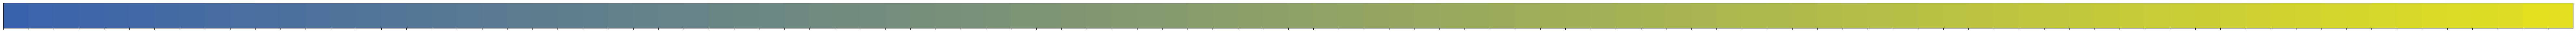

In [77]:
# Color by score
max_score_color = '#E3E020'
min_score_color = '#3962AD'
# create color scheme between
score_color_ls = make_gradient_color_scheme(101, # so goes 0 to 100
                                             [min_score_color,max_score_color])  
# remove every 6 elements to shorten list closer to 100
score_color_ls = [x for x in score_color_ls if x not in score_color_ls[::5]]
score_color_ls[100] = max_score_color
score_color_ls[0] = min_score_color

sns.palplot(score_color_ls)


# Plot Precision-Recall Curves


new list length is: 52


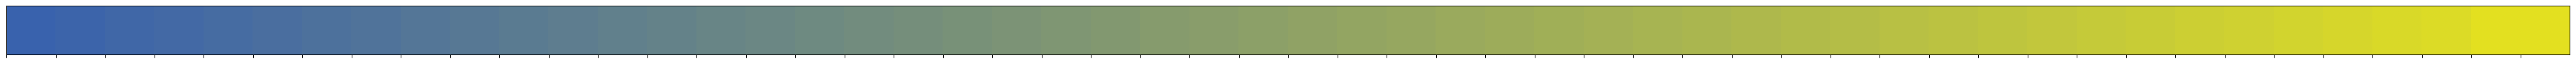

In [78]:
# make updated color scaling for ROC curves (since now 0.5-1.0 rather than 0-100)
max_score_color = '#E3E020'
min_score_color = '#3962AD'
# create color scheme between
prc_score_color_ls = make_gradient_color_scheme(51, 
                                             [min_score_color,max_score_color])  
prc_score_color_ls[50] = max_score_color
prc_score_color_ls[0] = min_score_color

print("new list length is:",len(prc_score_color_ls))
sns.palplot(prc_score_color_ls)



Figures saved to:
 p-r_curves_random_forest_k-fold_crossvalidation.svg 
 p-r_curves_random_forest_final.svg


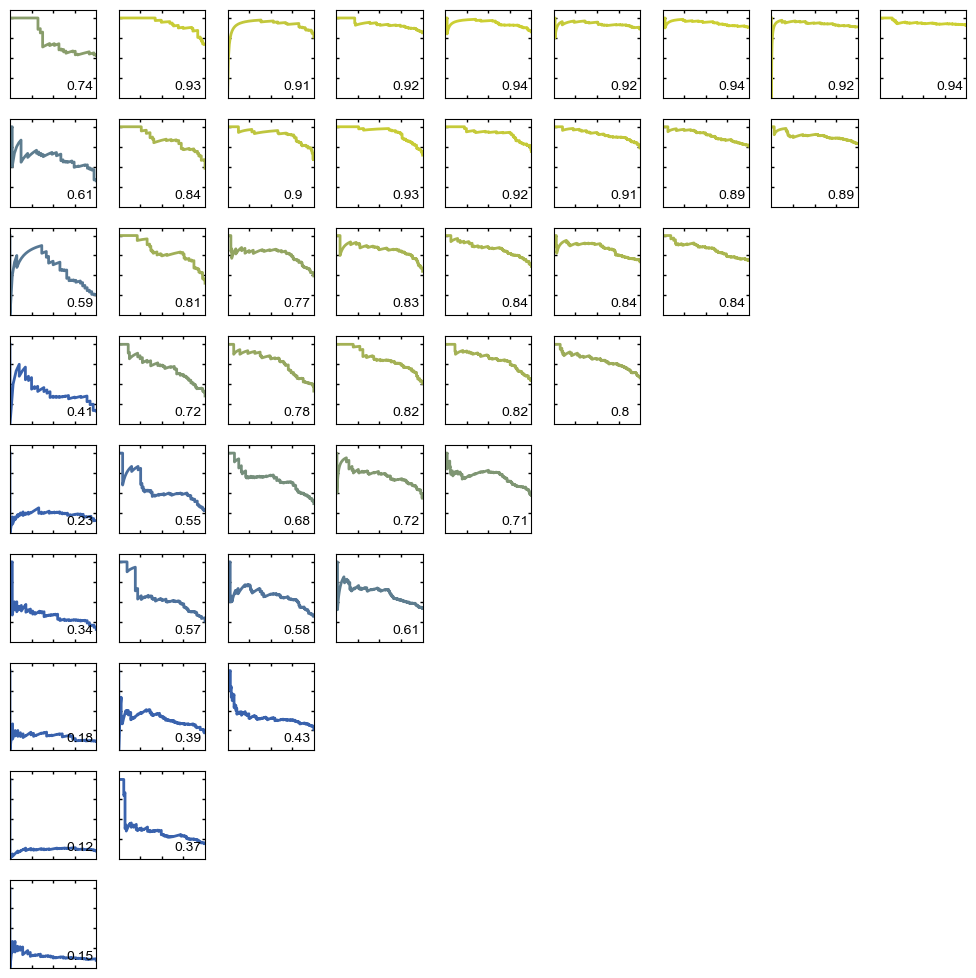

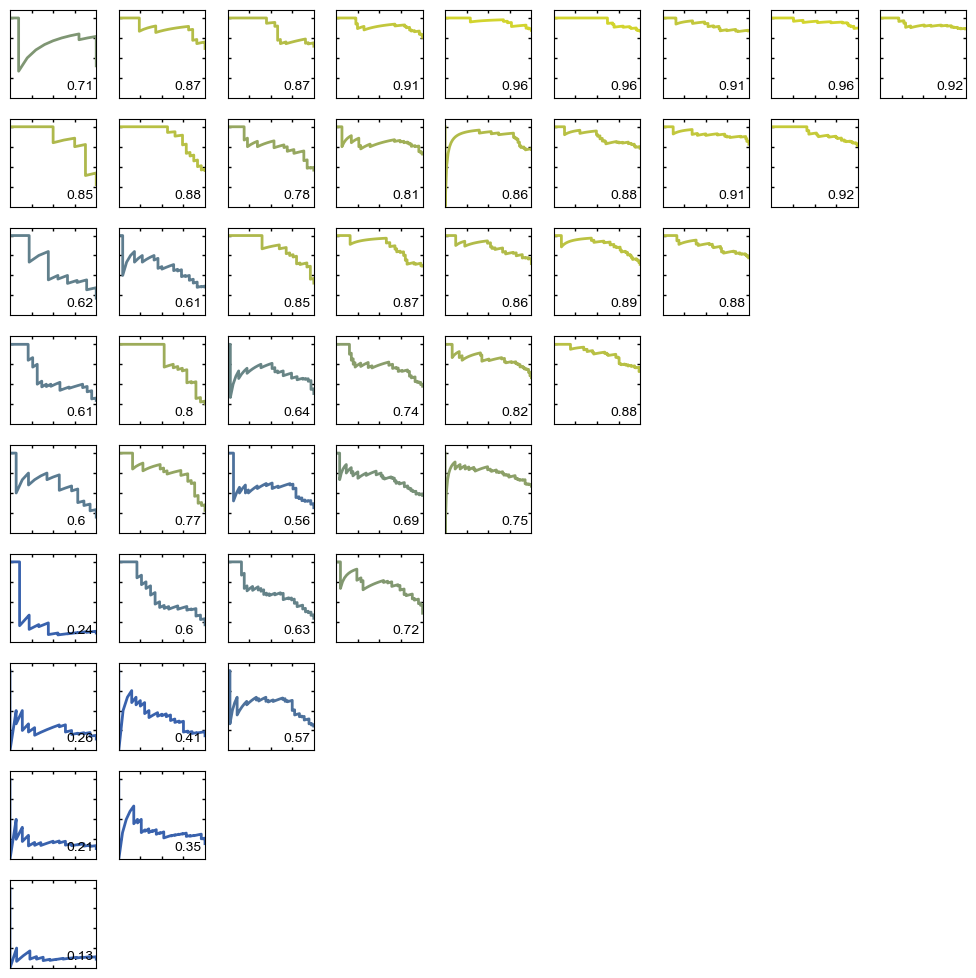

In [79]:
# # ** CONFIGURE FONTS **
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties
from matplotlib import rc
font_style = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 14,
        'style'  : 'normal'}

matplotlib.rc('font', **font_style)
matplotlib.rc('text', usetex=False) # updates fonts in text of plot

# dictionary of locations in plots based on cutoffs
#   x across y going down
plotting_dict_efficient =   {0: 6.9, 1: 10.3, 2: 15.0, 
                             3: 19.3, 4: 29.5, 5: 46.08, 
                             6: 60.0, 7: 75.0, 8: 90.0}

plotting_dict_inefficient = {8: 6.9, 7: 10.3, 6: 15.0, 
                             5: 19.3, 4: 29.5, 3: 46.08, 
                             2: 60.0, 1: 75.0, 0: 90.0}


# P-R curves K-fold cross-validation
fig1, axs1 = plt.subplots(9, 9)
fig1.set_size_inches(w = 10, h = 10)

# P-R curves Final
fig2, axs2 = plt.subplots(9, 9)
fig2.set_size_inches(w = 10, h = 10)

    
for y_coord in range(9):
    for x_coord in range(9):
        # get appropriate cutoff combination from co_combos and colname_ls
        e_co = plotting_dict_efficient[x_coord]
        i_co = plotting_dict_inefficient[y_coord]

        co_name = 'f_co_'+str(int(np.round(e_co,0)))+'%__nf_co_'+str(int(np.round(i_co,0)))+'%'
        
        if not co_name in colname_ls:
            # drop axes that aren't used
            axis = axs1[y_coord,x_coord]
            axis.remove()
            axis = axs2[y_coord,x_coord]
            axis.remove()
        else:
            combo_index = colname_ls.index(co_name) # use combo_index to search co_combos and colname_ls (along with model output lists)
            # plot for each figure
            axis = axs1[y_coord,x_coord] # must go y before x
            # get roc score
            prc_score = np.round(avg_prcroc_kflds[combo_index],2) 
                
            prc_score_col = int(100*(prc_score))-50
            if prc_score_col < 0:
                prc_score_col = 0
                
            lines = axis.plot(
                avg_prs_kflds[combo_index][0], # recall --> x
                avg_prs_kflds[combo_index][1], # precision --> y 
                linewidth = 2,
                color = prc_score_color_ls[prc_score_col]
                #color=score_color_ls[avg_aucpr_adj_kflds_norm[combo_index]]
            )
            # Set axes to start/end where desired
            axis.set_xlim(0,1)
            axis.set_ylim(0,1.1)
            # Format Axis - remove axis ticks
            axis.tick_params(reset = True, which='major',labelsize=12,length=2.5, width = 1, color='black',direction = 'in',left = True,labelleft = False,right= True,labelright = False,bottom = True,labelbottom = False,top= True, labeltop = False,)
            axis.set_yticks(ticks=[0.25,0.5,0.75,1.0])
            axis.set_xticks(ticks=[0.25,0.5,0.75])
            axis.set_yticklabels([])
            axis.set_xticklabels([])
            # Add Text (PRAUC/PRAUCadj/normalized PRAUCadf)
            # if avg_aucpr_adj_kflds_norm[combo_index] < 10: # single digit score
            #     x_score_posn = 0.8
            # elif avg_aucpr_adj_kflds_norm[combo_index] < 100: # double digit score
            #     x_score_posn = 0.7
            # else: # triple digit score (100)
            #     x_score_posn = 0.6
            # axis.text(x = x_score_posn, y = 0.1, 
            #           s = (str(np.round(avg_aucpr_adj_kflds_norm[combo_index],3))),
            #           fontsize=10,
            #          )
            
            axis.text(x = 0.65, y = 0.1, 
                      s = str(np.round(prc_score,2) ),
                      fontsize=10,
                     )

            # plot for each figure
            axis = axs2[y_coord,x_coord] # must go y before x
            prc_score_final = np.round(prcroc_finals[combo_index],2) 
            
            prc_score_final_col = int(100*(prc_score_final))-50
            if prc_score_final_col < 0:
                prc_score_final_col = 0


            lines = axis.plot(  
                prs_final[combo_index][0], # recall --> x
                prs_final[combo_index][1], # precision --> y
                linewidth = 2,
                color = prc_score_color_ls[prc_score_final_col]
                #color=score_color_ls[aucpr_adj_finals_norm[combo_index]]
            )
            # Set axes to start/end where desired
            axis.set_xlim(0,1)
            axis.set_ylim(0,1.1)
            # Format Axis - remove axis ticks
            axis.tick_params(reset = True, which='major',labelsize=12,length=2.5, width = 1, color='black',direction = 'in',left = True,labelleft = False,right= True,labelright = False,bottom = True,labelbottom = False,top= True, labeltop = False,)
            axis.set_yticks(ticks=[0.25,0.5,0.75,1.0])
            axis.set_xticks(ticks=[0.25,0.5,0.75])
            axis.set_yticklabels([])
            axis.set_xticklabels([])
            # Add Text (PRAUC/PRAUCadj/normalized PRAUCadf)
            # if aucpr_adj_finals_norm[combo_index] < 10: # single digit score
            #     x_score_posn = 0.8
            # elif aucpr_adj_finals_norm[combo_index] < 100: # double digit score
            #     x_score_posn = 0.7
            # else: # triple digit score (100)
            #     x_score_posn = 0.6
            # axis.text(x = x_score_posn, y = 0.3, 
            #           s = str(np.round(avg_aucpr_adj_kflds_norm[combo_index],3)),
            #           fontsize=10,
            #          )
            axis.text(x = 0.65, y = 0.1, 
                      s = str(prc_score_final),
                      fontsize=10,
                     )
                
# ** SAVE FIGURES **
plt.rcParams['svg.fonttype'] = 'none' # exports text as strings rather than vector paths (images)
fig1.tight_layout()
fig2.tight_layout()
fnm1 = ('p-r_curves'+'_random_forest'+'_k-fold_crossvalidation'+'.svg')
fnm2 = ('p-r_curves'+'_random_forest'+'_final'+'.svg')
fig1.savefig(outdir_plot+fnm1,format='svg',transparent=True)
fig2.savefig(outdir_plot+fnm2,format='svg',transparent=True)
print('Figures saved to:\n',fnm1,"\n",fnm2)            






# Plot Contingency Tables 
**NOTE**: this code make take ***a few minutes to run***

Figures saved to:
 confusion-matrices_random_forest_k-fold_crossvalidation.svg 
 confusion-matrices_random_forest_final.svg


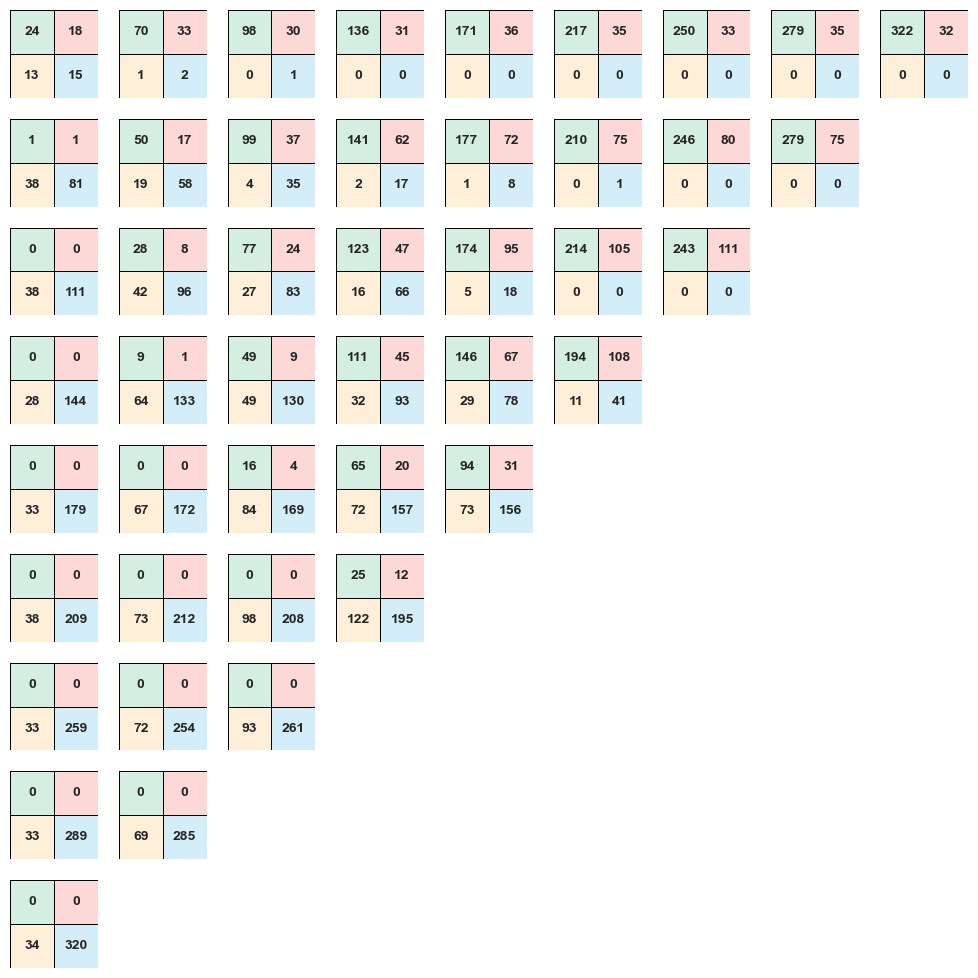

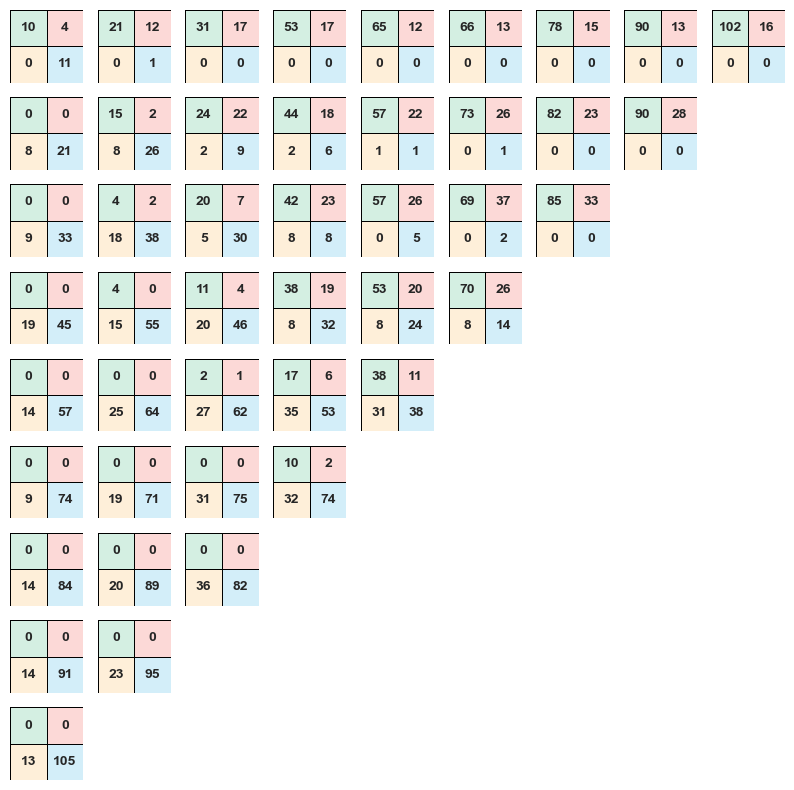

In [80]:
# Plot Contingency Tables

# Make color map for Contingency Tables 
from matplotlib.colors import LinearSegmentedColormap
conf_mtx_color_ls = ['#D4EFE2','#FCD9D7','#FEEFD9','#D3EEF9']
#sns.palplot(conf_mtx_color_ls)
# convert HEX color to RGB
conf_mtx_color_ls_asRGB = []
for c in conf_mtx_color_ls:
    hx = c.replace("#",'')
    rgb = tuple(int(hx[i:i+2], 16) for i in (0, 2, 4))
    conf_mtx_color_ls_asRGB.append(rgb)

# SCALE: convert RBG values to 0-1 scale (divide by 255)
scaled_rgb_compiled = []
for c in conf_mtx_color_ls_asRGB:
    scaled_rgb = []
    for i in range(len(c)):
        scaled_rgb.append(c[i]/255)# replace 1 with value
    scaled_rgb_compiled.append(tuple(scaled_rgb))
    
# tuple(scaled_rgb_compiled)
cmap_conf_mtxs = LinearSegmentedColormap.from_list('conf_matrix_color_map', conf_mtx_color_ls_asRGB, N=4)


# # ** CONFIGURE FONTS **
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties
from matplotlib import rc
font_style = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 14,
        'style'  : 'normal'}

matplotlib.rc('font', **font_style)
matplotlib.rc('text', usetex=False) # updates fonts in text of plot

# dictionary of locations in plots based on cutoffs
#   x across y going down
plotting_dict_efficient =   {0: 6.9, 1: 10.3, 2: 15.0, 
                             3: 19.3, 4: 29.5, 5: 46.08, 
                             6: 60.0, 7: 75.0, 8: 90.0}

plotting_dict_inefficient = {8: 6.9, 7: 10.3, 6: 15.0, 
                             5: 19.3, 4: 29.5, 3: 46.08, 
                             2: 60.0, 1: 75.0, 0: 90.0}



# Contingency Tables K-fold cross-validation
fig1, axs1 = plt.subplots(9, 9)
fig1.set_size_inches(w = 10, h = 10)

# Contingency Tables Final
fig2, axs2 = plt.subplots(9, 9)
fig2.set_size_inches(w = 10, h = 10)

    
for y_coord in range(9):
    for x_coord in range(9):
        # get appropriate cutoff combination from co_combos and colname_ls
        e_co = plotting_dict_efficient[x_coord]
        i_co = plotting_dict_inefficient[y_coord]

        co_name = 'f_co_'+str(int(np.round(e_co,0)))+'%__nf_co_'+str(int(np.round(i_co,0)))+'%'
        
        if not co_name in colname_ls:
            # drop axes that aren't used
            axis = axs1[y_coord,x_coord]
            axis.remove()
            axis = axs2[y_coord,x_coord]
            axis.remove()
        else:
            combo_index = colname_ls.index(co_name) # use combo_index to search co_combos and colname_ls (along with model output lists)
            # plot for each figure
            axis = axs1[y_coord,x_coord] # must go y before x
            
            # Remove ticks from table
            plt.rcParams['xtick.bottom'] = False
            plt.rcParams['ytick.left'] = False
            sns.heatmap(
                    avg_conf_mtx_kflds[combo_index], # this is the confusion matrix (same as contingency table)
                    xticklabels=[], yticklabels=[],
                    annot=True,# MUST BE TRUE FOR NUMBERS TO SHOW UP
                    fmt='g',# Disables scientific notation
                    cbar=False, # Removes colorbar
                    ax=axis, cmap=['white'],  linecolor='black',
                    annot_kws={"font":"Arial", "weight":'bold',"size":10},linewidths=0.5,
                   )
            # Color boxes 
            sns.heatmap(
                    [[1, 2], [3, 4]], # this is the confusion matrix (same as contingency table)
                    xticklabels=[], yticklabels=[],
                    annot=False,# MUST BE TRUE FOR NUMBERS TO SHOW UP
                    fmt='g',# Disables scientific notation
                    cbar=False, # Removes colorbar
                    ax=axis, 
                    cmap = LinearSegmentedColormap.from_list('conf_matrix_color_map', scaled_rgb_compiled, N=4),
                    linecolor='black',
                    annot_kws={"font":"Arial", "weight":'bold',"size":10},linewidths=0.5,
                   )

            # plot for each figure
            axis = axs2[y_coord,x_coord] # must go y before x
            
            # Remove ticks from table
            plt.rcParams['xtick.bottom'] = False
            plt.rcParams['ytick.left'] = False
            sns.heatmap(
                    conf_mtx_final[combo_index], # this is the confusion matrix (same as contingency table)
                    xticklabels=[], yticklabels=[],
                    annot=True,# MUST BE TRUE FOR NUMBERS TO SHOW UP
                    fmt='g',# Disables scientific notation
                    cbar=False, # Removes colorbar
                    ax=axis, cmap=['white'],  linecolor='black',
                    annot_kws={"font":"Arial", "weight":'bold',"size":10},linewidths=0.5,
                   )
            # Color boxes 
            sns.heatmap(
                    [[1, 2], [3, 4]], # this is the confusion matrix (same as contingency table)
                    xticklabels=[], yticklabels=[],
                    annot=False,# MUST BE TRUE FOR NUMBERS TO SHOW UP
                    fmt='g',# Disables scientific notation
                    cbar=False, # Removes colorbar
                    ax=axis, 
                    cmap = LinearSegmentedColormap.from_list('conf_matrix_color_map', scaled_rgb_compiled, N=4),
                    linecolor='black',
                    annot_kws={"font":"Arial", "weight":'bold',"size":10},linewidths=0.5,
                   )
            
                
# ** SAVE FIGURES **
plt.rcParams['svg.fonttype'] = 'none' # exports text as strings rather than vector paths (images)
fig1.tight_layout()
fig1.tight_layout()
fnm1 = ('confusion-matrices'+'_random_forest'+'_k-fold_crossvalidation'+'.svg')
fnm2 = ('confusion-matrices'+'_random_forest'+'_final'+'.svg')
fig1.savefig(outdir_plot+fnm1,format='svg',transparent=True)
fig2.savefig(outdir_plot+fnm2,format='svg',transparent=True)
print('Figures saved to:\n',fnm1,"\n",fnm2)            
    


    


# Plot ROC Cruves

new list length is: 52


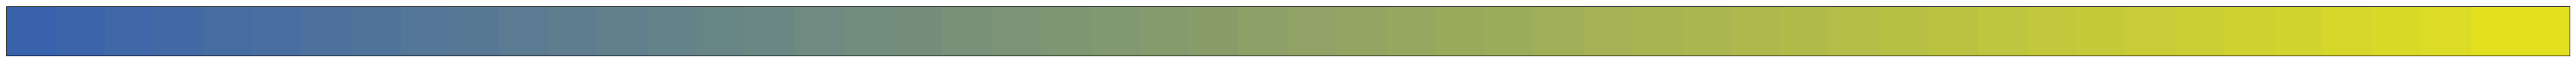

In [81]:
# make updated color scaling for ROC curves (since now 0.5-1.0 rather than 0-100)
max_score_color = '#E3E020'
min_score_color = '#3962AD'
# create color scheme between
roc_score_color_ls = make_gradient_color_scheme(51, 
                                             [min_score_color,max_score_color])  
roc_score_color_ls[50] = max_score_color
roc_score_color_ls[0] = min_score_color

print("new list length is:",len(roc_score_color_ls))
sns.palplot(roc_score_color_ls)



Figures saved to:
 roc_curves_random_forest_k-fold_crossvalidation.svg 
 roc_curves_random_forest_final.svg


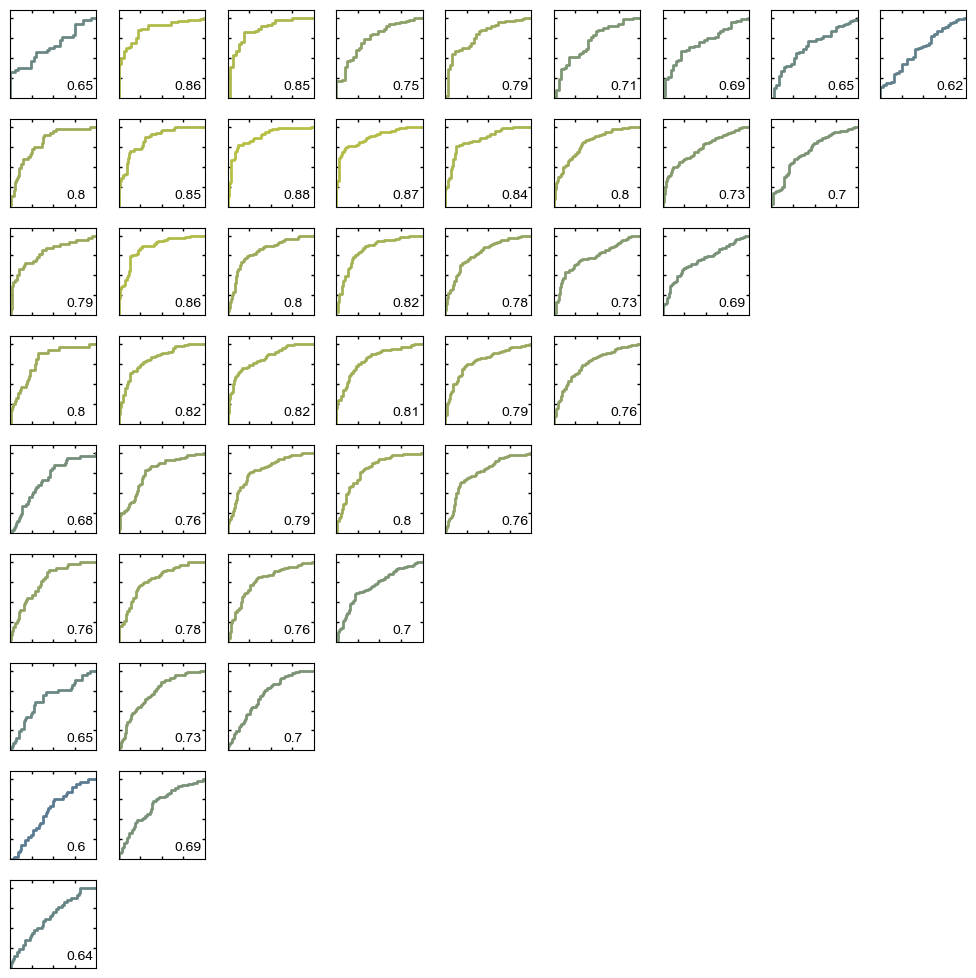

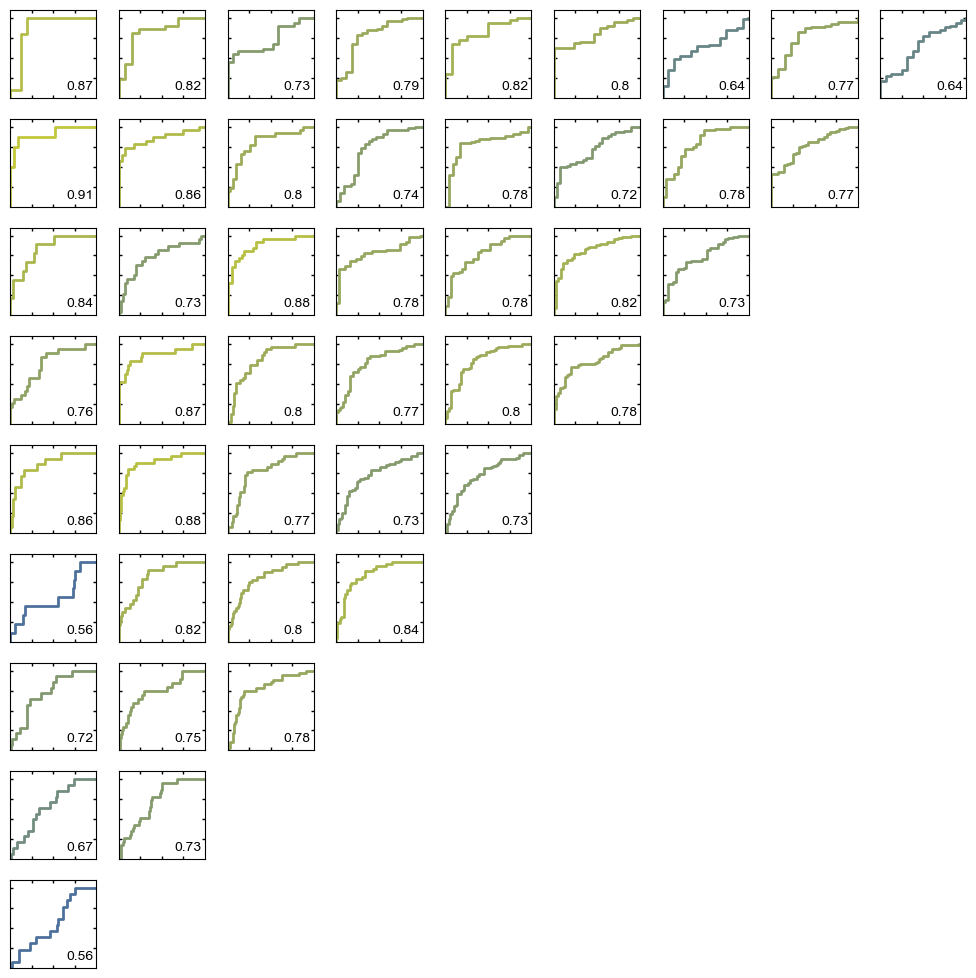

In [82]:
# Plot ROC Curves

# # ** CONFIGURE FONTS **
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties
from matplotlib import rc
font_style = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 14,
        'style'  : 'normal'}

matplotlib.rc('font', **font_style)
matplotlib.rc('text', usetex=False) # updates fonts in text of plot

# dictionary of locations in plots based on cutoffs
#   x across y going down
plotting_dict_efficient =   {0: 6.9, 1: 10.3, 2: 15.0, 
                             3: 19.3, 4: 29.5, 5: 46.08, 
                             6: 60.0, 7: 75.0, 8: 90.0}

plotting_dict_inefficient = {8: 6.9, 7: 10.3, 6: 15.0, 
                             5: 19.3, 4: 29.5, 3: 46.08, 
                             2: 60.0, 1: 75.0, 0: 90.0}


# P-R curves K-fold cross-validation
fig1, axs1 = plt.subplots(9, 9)
fig1.set_size_inches(w = 10, h = 10)

# P-R curves Final
fig2, axs2 = plt.subplots(9, 9)
fig2.set_size_inches(w = 10, h = 10)

    
for y_coord in range(9):
    for x_coord in range(9):
        # get appropriate cutoff combination from co_combos and colname_ls
        e_co = plotting_dict_efficient[x_coord]
        i_co = plotting_dict_inefficient[y_coord]

        co_name = 'f_co_'+str(int(np.round(e_co,0)))+'%__nf_co_'+str(int(np.round(i_co,0)))+'%'
        
        if not co_name in colname_ls:
            # drop axes that aren't used
            axis = axs1[y_coord,x_coord]
            axis.remove()
            axis = axs2[y_coord,x_coord]
            axis.remove()
        else:
            combo_index = colname_ls.index(co_name) # use combo_index to search co_combos and colname_ls (along with model output lists)
            # plot for each figure
            axis = axs1[y_coord,x_coord] # must go y before x
            # get roc score
            roc_score = np.round(avg_aucroc_kflds[combo_index],2) 
                
            roc_score_col = int(100*(roc_score))-50
            if roc_score_col < 0:
                roc_score_col = 0
                
            lines = axis.plot(
                avg_roc_kflds[combo_index][0], # fpr -> x
                avg_roc_kflds[combo_index][1], # tpr -> y
                linewidth = 2,
                color=roc_score_color_ls[roc_score_col]
            )
            # Set axes to start/end where desired
            axis.set_xlim(0,1)
            axis.set_ylim(0,1.1)
            # Format Axis - remove axis ticks
            axis.tick_params(reset = True, which='major',labelsize=12,length=2.5, width = 1, color='black',direction = 'in',left = True,labelleft = False,right= True,labelright = False,bottom = True,labelbottom = False,top= True, labeltop = False,)
            axis.set_yticks(ticks=[0.25,0.5,0.75,1.0])
            axis.set_xticks(ticks=[0.25,0.5,0.75])
            axis.set_yticklabels([])
            axis.set_xticklabels([])

            # Add Text (ROC Score)
            axis.text(x = 0.65, y = 0.1, 
                      s = str(np.round(roc_score,2) ),
                      fontsize=10,
                     )
            
            # plot for each figure
            axis = axs2[y_coord,x_coord] # must go y before x
                      
            roc_score_final = np.round(aucroc_finals[combo_index],2) 
            
            roc_score_final_col = int(100*(roc_score_final))-50
            if roc_score_final_col < 0:
                roc_score_final_col = 0
                
            lines = axis.plot(
                roc_final[combo_index][0], # fpr -> x
                roc_final[combo_index][1], # tpr -> y
                linewidth = 2,
                color=roc_score_color_ls[roc_score_final_col],
            )
            # Set axes to start/end where desired
            axis.set_xlim(0,1)
            axis.set_ylim(0,1.1)
            # Format Axis - remove axis ticks
            axis.tick_params(reset = True, which='major',labelsize=12,length=2.5, width = 1, color='black',direction = 'in',left = True,labelleft = False,right= True,labelright = False,bottom = True,labelbottom = False,top= True, labeltop = False,)
            axis.set_yticks(ticks=[0.25,0.5,0.75,1.0])
            axis.set_xticks(ticks=[0.25,0.5,0.75])
            axis.set_yticklabels([])
            axis.set_xticklabels([])
                      
            # Add Text (ROC Score)
            axis.text(x = 0.65, y = 0.1, 
                      s = str(roc_score_final),
                      fontsize=10,
                     )
                
                
# ** SAVE FIGURES **
plt.rcParams['svg.fonttype'] = 'none' # exports text as strings rather than vector paths (images)
fig1.tight_layout()
fig2.tight_layout()
fnm1 = ('roc_curves'+'_random_forest'+'_k-fold_crossvalidation'+'.svg')
fnm2 = ('roc_curves'+'_random_forest'+'_final'+'.svg')
fig1.savefig(outdir_plot+fnm1,format='svg',transparent=True)
fig2.savefig(outdir_plot+fnm2,format='svg',transparent=True)
print('Figures saved to:\n',fnm1,"\n",fnm2)





# Get metrics

In [88]:
len(f1_final)
for i in range(len(co_combos)):
    if colname_ls[i] == 'f_co_30%__nf_co_30%':
        print(colname_ls[i])
        print('f1:',f1_final[i])
        print('auc:',aucroc_finals[i])
        print('prc:',prcroc_finals[i])

f_co_30%__nf_co_30%
f1: 0.6440677966101694
auc: 0.7261165335699498
prc: 0.7500158371693643


# Build Weight Matrix 
For selected threshold combination


In [84]:
# Extract Feature Preferences from selected final model
import pickle
# load selected in model
final_model_thresholds = 'f_co_30%__nf_co_30%' # Update this to selected Final Model thresholds

final_model_file = 'FINAL-MODEL_'+final_model_thresholds+'_rf'+'.sav'
clf = pickle.load(open(outdir_model+final_model_file, 'rb'))
print("loading existing model:",final_model_file)
# Use ENTIRE dataset
X_test = df[df[final_model_thresholds+'_class'] != 'excluded']['encoded_19mer']
y_test = df[df[final_model_thresholds+'_class'] != 'excluded'][final_model_thresholds+'_class'].map(class_dict)     

# Evaluate Model (Classifier) on Test Set
y_score = clf.predict_proba(list(X_test))[:,1]
y_pred  = clf.predict(list(X_test))

df_score = pd.DataFrame({'actual':y_test,'predicted':y_pred,'prob':y_score,'encoded_19mer':X_test})
#display(df_score)


# Identify prediction classes (TP/TN/FN/FP) 
def get_prediction_class(x):
    if x['actual'] == 1: # is actually positive
        if x['predicted'] == 1: # correct prediction
            return "TP"
        else: # incorrectly predicted to be negative
            return "FN" 
    else: # is actually negative
        if x['predicted'] == 1: # incorrectly predicted to be positive
            return "FP"
        else: # correctly predicted to be negative
            return "TN"


df_score['pred_class'] = df_score[['actual','predicted']].apply(lambda x: get_prediction_class(x), axis =1)

# Compute weights - frequencies of each base at each position averaged over the entire prediction class
#        * frequencies are calculated from encoded sequence
# get encoded sequences with given prediction class (True Positives)
freq_TP_df = pd.DataFrame(list(df_score[df_score['pred_class'] == 'TP']['encoded_19mer'] ))
# compute average frequencies of encoded sequences across 20mer (80 total features - 4 base * 20 positions) for given prediction class
avg_TP = freq_TP_df.apply(lambda x: np.average(x))

# get encoded sequences with given prediction class (True Negatives)
freq_TN_df = pd.DataFrame(list(df_score[df_score['pred_class'] == 'TN']['encoded_19mer'] ))
# compute average frequencies of encoded sequences across 20mer (80 total features - 4 base * 20 positions) for given prediction class
avg_TN = freq_TN_df.apply(lambda x: np.average(x))

# get encoded sequences with given prediction class (False Positives)
freq_FP_df = pd.DataFrame(list(df_score[df_score['pred_class'] == 'FP']['encoded_19mer'] ))
# compute average frequencies of encoded sequences across 20mer (80 total features - 4 base * 20 positions) for given prediction class
avg_FP = freq_FP_df.apply(lambda x: np.average(x))

# get encoded sequences with given prediction class (False Negatives)
freq_FN_df = pd.DataFrame(list(df_score[df_score['pred_class'] == 'FN']['encoded_19mer'] ))
# compute average frequencies of encoded sequences across 20mer (80 total features - 4 base * 20 positions) for given prediction class
avg_FN = freq_FN_df.apply(lambda x: np.average(x))

# Sum weights across 20mer sequence for all 80 features (4 bases * 20 positions) 
#    False Negatives are incorrect predictions so multiply by -1
#    False Positives are incorrect predictions so multiply by -1
sum_weights = ((avg_TP) + (avg_TN) + (-1*avg_FP) + (-1*avg_FN))


# Convert to weight matrix - numbers are based on how the bases were encoded (see encode_sequence method above)
#      base_dict = {'A':[1,0,0,0],'U':[0,1,0,0],'C':[0,0,1,0],'G':[0,0,0,1]}
a_imps = list(sum_weights[::4])
u_imps = list(sum_weights[1::4])
c_imps = list(sum_weights[2::4])
g_imps = list(sum_weights[3::4])

weight_matrix_proxy = pd.DataFrame({"A":a_imps,"U":u_imps,"C":c_imps,"G":g_imps,})

# Normalize weights
largest = max(max(weight_matrix_proxy['A']),max(weight_matrix_proxy['U']),max(weight_matrix_proxy['C']),max(weight_matrix_proxy['G']))
smallest = min(min(weight_matrix_proxy['A']),min(weight_matrix_proxy['U']),min(weight_matrix_proxy['C']),min(weight_matrix_proxy['G']))
if abs(smallest) > largest:
    norm_val = abs(smallest)
else:
    norm_val = largest
weight_matrix_proxy = weight_matrix_proxy.apply(lambda x: np.round((100*(x/norm_val)),0)).astype('int64')

# cutoff at 20
weight_matrix_proxy = weight_matrix_proxy.where((weight_matrix_proxy > 20) | ( weight_matrix_proxy < -20), 0)

display(weight_matrix_proxy.transpose())






loading existing model: FINAL-MODEL_f_co_30%__nf_co_30%_rf.sav


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
A,54,0,-48,33,24,49,0,0,-100,0,0,-35,0,32,0,21,25,-62,32
U,-73,-30,95,-69,0,-28,-66,39,0,22,-23,-23,43,0,0,-24,71,43,43
C,23,0,-96,-26,0,-79,0,-62,22,0,53,60,-70,-47,0,0,-83,28,0
G,0,35,48,63,0,59,43,0,86,-32,-37,0,41,34,-29,0,0,0,-59


Figure saved to:
 weight_matrix_FINAL-MODEL_f_co_30%__nf_co_30%_rf.sav.svg


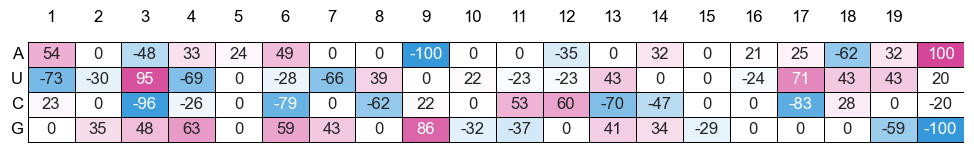

In [85]:
# Plot Weight Matrix
weight_matrix_to_plot = weight_matrix_proxy

# add extra row that will be deleted later just for coloring matrix
weight_matrix_to_plot = pd.concat((weight_matrix_to_plot,pd.DataFrame({"A":[100],"U":[20],"C":[-20],"G":[-100]}))) #weight_matrix_to_plot.append(pd.DataFrame({"A":[100],"U":[20],"C":[-20],"G":[-100]}))

weight_matrix_to_plot = weight_matrix_to_plot.transpose()

weight_matrix_to_plot.columns = [str(x) for x in list(range(1,20))]+['']

# plot the map
font = {'weight' : 'normal','size'   : 12, "family":'sans-serif',"sans-serif":'Arial'}
matplotlib.rc('font', **font)

positive_color ="#d54699"
negative_color =  "#3498db"

norm = matplotlib.colors.Normalize(-100,100)
colors = [[norm(-100), negative_color],
          [norm(-20), "white"],
          [norm(0), "white"],
          [norm( 20), "white"],
          [norm( 100), positive_color]]

cm = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
fig = plt.figure(figsize=((5.5*1.8,1*1.8)))

ax = sns.heatmap(weight_matrix_to_plot,
                      annot=True,
                      cmap=cm,
                      linewidths=0.5,linecolor='black',fmt='g',cbar=False)
ax.xaxis.set_ticks_position('top')
ax.tick_params(axis=u'both', which=u'both',length=0) # remove tick lines
ax.tick_params(rotation=0)


# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

# Create a Rectangle patch to hide last collumn
rect = matplotlib.patches.Rectangle((20.01,-2 ), 2, 50, edgecolor='none', facecolor='white',zorder=99)
ax.add_patch(rect)

# ** SAVE FIGURE **
plt.rcParams['svg.fonttype'] = 'none' # exports text as strings rather than vector paths (images)
fig.tight_layout()
fnm = ('weight_matrix_'+final_model_file+'.svg')
fig.savefig(outdir_plot+fnm,format='svg',transparent=True)
print('Figure saved to:\n',fnm)

